In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [2]:
def format_model_name(key):
    if key == 'rnn':
        return 'RNN-SF'
    elif key == 'rnn_oja':
        return 'RNN-Oja'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [4]:
hue_order = [
    #'Linear',
    'RNN-SF',
    'MLP with Replay Buffer',
    #'RNN-Oja',
    #'Linear'
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [5]:
# Collect measures of all iterations
root_dir = "/home/chingf/engram/Ching/03_td_discrete_corr/"

init_sparsities = []
final_sparsities = []
sigmas = []
gammas = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []
chance_losses = []

for sparsity_dir in os.listdir(root_dir):
    if 'sparsity' not in sparsity_dir: continue
    for sigma_dir in os.listdir(f'{root_dir}{sparsity_dir}/'):
        for gamma_dir in os.listdir(f'{root_dir}{sparsity_dir}/{sigma_dir}/'):
            path = f'{root_dir}{sparsity_dir}/{sigma_dir}/{gamma_dir}/'
            print(path)
            
            # Get dataset parameters
            init_sparsity = get_sparsity(path)
            sigma = get_sigma(path)
            gamma = float(gamma_dir)
            
            # Iterate over models
            for model_dir in os.listdir(path):
                try:
                    model = format_model_name(model_dir)
                except:
                    continue
                model_path = f'{path}{model_dir}/'
                    
                # Gather metrics for each model iteration
                for iter_dir in os.listdir(model_path):
                    iter_path = model_path + iter_dir + '/'
                    if not os.path.isfile(iter_path + 'results.p'):
                        continue
                    for file in os.listdir(iter_path):
                        print(file)
                        if 'tfevents' not in file: continue
                        tfevents_file = iter_path + '/' + file
                        event_acc = EventAccumulator(tfevents_file)
                        event_acc.Reload()
                        try:
                            scalar_events = event_acc.Scalars('loss_train')
                        except:
                            continue
                        values = np.array([event.value for event in scalar_events])
                        if np.any(np.isnan(values)): continue
                        steps = np.array([event.step for event in scalar_events])
                        central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                        if values[0] > values[-1]: # decreasing
                            val95 = values[0] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values <= val95)[0][0]
                        else: # increasing
                            val95 = values[-1] - abs(values[0] - values[-1])*0.95
                            time_to_95 = np.argwhere(values >= val95)[0][0]
                        
                        init_sparsities.append(init_sparsity)
                        results = pickle.load(open(iter_path + 'results.p', 'rb'))
                        final_sparsities.append(results['dset'].feature_maker.post_smooth_sparsity)
                        sigmas.append(sigma)
                        gammas.append(gamma)
                        models.append(model)
                        start_losses.append(values[0])
                        time_to_elbows.append(steps[time_to_95])
                        #time_to_elbows.append(steps[np.argmax(central_diffs)])
                        final_losses.append(values[-1])
                        if 'mlp' in model_dir:
                            chance_losses.append(np.nan)
                        else:
                            chance_losses.append(event_acc.Scalars('chance_loss')[-1].value)
                        break

init_sparsities = np.array(init_sparsities)
final_sparsities = np.array(final_sparsities)
sigmas = np.array(sigmas)
gammas = np.array(gammas)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)
chance_losses = np.array(chance_losses)

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0448421052631579/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641563957.mushroombody.aronov.zi.columbia.edu.43084.139
results.p
model.pt
field_infos.p
events.out.tfevents.1641563791.mushroombody.aronov.zi.columbia.edu.43084.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641563875.mushroombody.aronov.zi.columbia.edu.43084.138
results.p
model.pt
events.out.tfevents.1641560186.mushroombody.aronov.zi.columbia.edu.43084.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641553237.mushroombody.aronov.zi.columbia.edu.43084.127
results.p
model.pt
field_infos.p
events.out.tfevents.1641556695.mushroombody.aronov.zi.columbia.edu.43084.128
results.p
events.out.tfevents.1641563783.mushroombody.aronov.zi.columbia.edu.43084.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641563766.mushroombody.aronov.zi.columbia.edu.43084.134
results.p
events.out.tfevents.1641563774.mushroombody.aronov.zi.columb

events.out.tfevents.1642521464.mushroombody.aronov.zi.columbia.edu.29074.96
results.p
model.pt
field_infos.p
events.out.tfevents.1642521446.mushroombody.aronov.zi.columbia.edu.29074.94
results.p
events.out.tfevents.1642521455.mushroombody.aronov.zi.columbia.edu.29074.95
events.out.tfevents.1642515696.mushroombody.aronov.zi.columbia.edu.29074.84
results.p
model.pt
field_infos.p
events.out.tfevents.1642512984.mushroombody.aronov.zi.columbia.edu.29074.82
results.p
events.out.tfevents.1642514486.mushroombody.aronov.zi.columbia.edu.29074.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06068421052631579/sigma0.25/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1642481556.mushroombody.aronov.zi.columbia.edu.29025.19
results.p
events.out.tfevents.1642481291.mushroombody.aronov.zi.columbia.edu.29025.17
results.p
events.out.tfevents.1642481433.mushroombody.aronov.zi.columbia.edu.29025.18
results.p
events.out.tfevents.1642475425.mushroombody.aronov.zi.columbia.edu.29025.9
re

events.out.tfevents.1641293482.mushroombody.aronov.zi.columbia.edu.34083.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641290123.mushroombody.aronov.zi.columbia.edu.34083.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641291793.mushroombody.aronov.zi.columbia.edu.34083.28
events.out.tfevents.1641295262.mushroombody.aronov.zi.columbia.edu.34083.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641295232.mushroombody.aronov.zi.columbia.edu.34083.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641295242.mushroombody.aronov.zi.columbia.edu.34083.35
events.out.tfevents.1641286645.mushroombody.aronov.zi.columbia.edu.34083.24
results.p
events.out.tfevents.1641283281.mushroombody.aronov.zi.columbia.edu.34083.22
events.out.tfevents.1641284960.mushroombody.aronov.zi.columbia.edu.34083.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157895/sigma1.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641773521.mushroombody.aronov.z

results.p
events.out.tfevents.1641445641.mushroombody.aronov.zi.columbia.edu.43076.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1601578947368421/sigma0.25/0.8/
results.p
events.out.tfevents.1642524179.mushroombody.aronov.zi.columbia.edu.29064.59
results.p
events.out.tfevents.1642524100.mushroombody.aronov.zi.columbia.edu.29064.57
events.out.tfevents.1642524140.mushroombody.aronov.zi.columbia.edu.29064.58
results.p
model.pt
events.out.tfevents.1642522422.mushroombody.aronov.zi.columbia.edu.29064.49
results.p
model.pt
field_infos.p
events.out.tfevents.1642514086.mushroombody.aronov.zi.columbia.edu.29064.47
results.p
model.pt
events.out.tfevents.1642518586.mushroombody.aronov.zi.columbia.edu.29064.48
results.p
events.out.tfevents.1642524095.mushroombody.aronov.zi.columbia.edu.29064.56
results.p
model.pt
field_infos.p
events.out.tfevents.1642524083.mushroombody.aronov.zi.columbia.edu.29064.54
events.out.tfevents.1642524088.mushroombody.aronov.zi.columbia.edu.29064.55
results.

results.p
model.pt
field_infos.p
events.out.tfevents.1641781557.mushroombody.aronov.zi.columbia.edu.14643.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776826.mushroombody.aronov.zi.columbia.edu.14643.24
events.out.tfevents.1641775050.mushroombody.aronov.zi.columbia.edu.14643.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641775937.mushroombody.aronov.zi.columbia.edu.14643.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.015052631578947366/sigma1.25/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641439837.mushroombody.aronov.zi.columbia.edu.43088.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439651.mushroombody.aronov.zi.columbia.edu.43088.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641439742.mushroombody.aronov.zi.columbia.edu.43088.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641436819.mushroombody.aronov.zi.columbia.edu.43088.9
results.p
model.pt
events.out.tfevents.1641431297.mushroombody.aronov.z

results.p
model.pt
field_infos.p
events.out.tfevents.1641501732.mushroombody.aronov.zi.columbia.edu.43065.78
events.out.tfevents.1641499077.mushroombody.aronov.zi.columbia.edu.43065.69
results.p
events.out.tfevents.1641494361.mushroombody.aronov.zi.columbia.edu.43065.67
results.p
events.out.tfevents.1641496670.mushroombody.aronov.zi.columbia.edu.43065.68
events.out.tfevents.1641501544.mushroombody.aronov.zi.columbia.edu.43065.76
events.out.tfevents.1641501509.mushroombody.aronov.zi.columbia.edu.43065.74
events.out.tfevents.1641501526.mushroombody.aronov.zi.columbia.edu.43065.75
events.out.tfevents.1641490106.mushroombody.aronov.zi.columbia.edu.43065.64
events.out.tfevents.1641486999.mushroombody.aronov.zi.columbia.edu.43065.62
events.out.tfevents.1641488519.mushroombody.aronov.zi.columbia.edu.43065.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641789576.mushroombody.aronov.zi.columbia.e

results.p
model.pt
events.out.tfevents.1641582640.mushroombody.aronov.zi.columbia.edu.43120.157
results.p
model.pt
field_infos.p
events.out.tfevents.1641582695.mushroombody.aronov.zi.columbia.edu.43120.158
results.p
model.pt
field_infos.p
events.out.tfevents.1641581054.mushroombody.aronov.zi.columbia.edu.43120.149
results.p
events.out.tfevents.1641577906.mushroombody.aronov.zi.columbia.edu.43120.147
results.p
model.pt
events.out.tfevents.1641579496.mushroombody.aronov.zi.columbia.edu.43120.148
events.out.tfevents.1641582635.mushroombody.aronov.zi.columbia.edu.43120.156
results.p
events.out.tfevents.1641582625.mushroombody.aronov.zi.columbia.edu.43120.154
results.p
model.pt
field_infos.p
events.out.tfevents.1641582630.mushroombody.aronov.zi.columbia.edu.43120.155
events.out.tfevents.1641574594.mushroombody.aronov.zi.columbia.edu.43120.144
results.p
model.pt
field_infos.p
events.out.tfevents.1641568849.mushroombody.aronov.zi.columbia.edu.43120.142
results.p
model.pt
field_infos.p
events.

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03/sigma2.5/0.75/
events.out.tfevents.1641484764.mushroombody.aronov.zi.columbia.edu.43099.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641484589.mushroombody.aronov.zi.columbia.edu.43099.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641484680.mushroombody.aronov.zi.columbia.edu.43099.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641481802.mushroombody.aronov.zi.columbia.edu.43099.49
events.out.tfevents.1641476391.mushroombody.aronov.zi.columbia.edu.43099.47
events.out.tfevents.1641479084.mushroombody.aronov.zi.columbia.edu.43099.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641484580.mushroombody.aronov.zi.columbia.edu.43099.56
results.p
events.out.tfevents.1641484564.mushroombody.aronov.zi.columbia.edu.43099.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641484572.mushroombody.aronov.zi.columbia.edu.43099.55
results.p
events.out.tfevents.1641470731.mushroombody.aronov.zi.col

results.p
events.out.tfevents.1641475815.mushroombody.aronov.zi.columbia.edu.43075.54
events.out.tfevents.1641475823.mushroombody.aronov.zi.columbia.edu.43075.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641467808.mushroombody.aronov.zi.columbia.edu.43075.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641464687.mushroombody.aronov.zi.columbia.edu.43075.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641466254.mushroombody.aronov.zi.columbia.edu.43075.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06373684210526316/sigma0.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781580.mushroombody.aronov.zi.columbia.edu.14587.39
events.out.tfevents.1641781402.mushroombody.aronov.zi.columbia.edu.14587.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641781491.mushroombody.aronov.zi.columbia.edu.14587.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641780456.mushroombody.aronov.zi.columbia.edu.14587.29
results.p
model.pt
f

results.p
model.pt
field_infos.p
events.out.tfevents.1642515762.mushroombody.aronov.zi.columbia.edu.29035.28
results.p
events.out.tfevents.1642523373.mushroombody.aronov.zi.columbia.edu.29035.36
results.p
events.out.tfevents.1642523362.mushroombody.aronov.zi.columbia.edu.29035.34
results.p
model.pt
field_infos.p
events.out.tfevents.1642523367.mushroombody.aronov.zi.columbia.edu.29035.35
events.out.tfevents.1642501276.mushroombody.aronov.zi.columbia.edu.29035.24
results.p
model.pt
field_infos.p
events.out.tfevents.1642489568.mushroombody.aronov.zi.columbia.edu.29035.22
results.p
events.out.tfevents.1642494774.mushroombody.aronov.zi.columbia.edu.29035.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.10047368421052633/sigma0.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1642489071.mushroombody.aronov.zi.columbia.edu.29076.39
results.p
model.pt
field_infos.p
events.out.tfevents.1642488669.mushroombody.aronov.zi.columbia.edu.29076.37
results.p
model.pt
field_infos.p

results.p
events.out.tfevents.1641436416.mushroombody.aronov.zi.columbia.edu.43138.9
events.out.tfevents.1641430987.mushroombody.aronov.zi.columbia.edu.43138.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641433722.mushroombody.aronov.zi.columbia.edu.43138.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439180.mushroombody.aronov.zi.columbia.edu.43138.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641439162.mushroombody.aronov.zi.columbia.edu.43138.14
results.p
events.out.tfevents.1641439171.mushroombody.aronov.zi.columbia.edu.43138.15
events.out.tfevents.1641425042.mushroombody.aronov.zi.columbia.edu.43138.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641419696.mushroombody.aronov.zi.columbia.edu.43138.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641422361.mushroombody.aronov.zi.columbia.edu.43138.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.8/
results.p
events.out.tfevents.1641565043.mushroo

results.p
model.pt
field_infos.p
events.out.tfevents.1641796967.mushroombody.aronov.zi.columbia.edu.14617.77
results.p
events.out.tfevents.1641797048.mushroombody.aronov.zi.columbia.edu.14617.78
results.p
model.pt
events.out.tfevents.1641796015.mushroombody.aronov.zi.columbia.edu.14617.69
results.p
model.pt
events.out.tfevents.1641794264.mushroombody.aronov.zi.columbia.edu.14617.67
results.p
events.out.tfevents.1641795139.mushroombody.aronov.zi.columbia.edu.14617.68
results.p
events.out.tfevents.1641796959.mushroombody.aronov.zi.columbia.edu.14617.76
events.out.tfevents.1641796943.mushroombody.aronov.zi.columbia.edu.14617.74
results.p
events.out.tfevents.1641796951.mushroombody.aronov.zi.columbia.edu.14617.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641792359.mushroombody.aronov.zi.columbia.edu.14617.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641790598.mushroombody.aronov.zi.columbia.edu.14617.62
results.p
model.pt
events.out.tfevents.1641791481.mushroombody.

results.p
events.out.tfevents.1641522485.mushroombody.aronov.zi.columbia.edu.43129.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.047842105263157894/sigma1.25/0.6/
events.out.tfevents.1641489053.mushroombody.aronov.zi.columbia.edu.43070.79
results.p
events.out.tfevents.1641488872.mushroombody.aronov.zi.columbia.edu.43070.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641488973.mushroombody.aronov.zi.columbia.edu.43070.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641487280.mushroombody.aronov.zi.columbia.edu.43070.69
events.out.tfevents.1641484069.mushroombody.aronov.zi.columbia.edu.43070.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641485701.mushroombody.aronov.zi.columbia.edu.43070.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641488863.mushroombody.aronov.zi.columbia.edu.43070.76
results.p
events.out.tfevents.1641488847.mushroombody.aronov.zi.columbia.edu.43070.74
events.out.tfevents.1641488855.mushroombody.aronov.zi.columbia.

results.p
events.out.tfevents.1641448684.mushroombody.aronov.zi.columbia.edu.43102.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641443084.mushroombody.aronov.zi.columbia.edu.43102.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641445855.mushroombody.aronov.zi.columbia.edu.43102.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0040526315789473685/sigma2.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641573804.mushroombody.aronov.zi.columbia.edu.5949.19
events.out.tfevents.1641573672.mushroombody.aronov.zi.columbia.edu.5949.17
results.p
events.out.tfevents.1641573744.mushroombody.aronov.zi.columbia.edu.5949.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641570328.mushroombody.aronov.zi.columbia.edu.5949.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641563154.mushroombody.aronov.zi.columbia.edu.5949.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641566761.mushroombody.aronov.zi.columbia.edu.5949.8
results.p
events.

results.p
events.out.tfevents.1642501181.mushroombody.aronov.zi.columbia.edu.29074.56
events.out.tfevents.1642501145.mushroombody.aronov.zi.columbia.edu.29074.54
results.p
model.pt
events.out.tfevents.1642501160.mushroombody.aronov.zi.columbia.edu.29074.55
events.out.tfevents.1642493333.mushroombody.aronov.zi.columbia.edu.29074.44
results.p
model.pt
field_infos.p
events.out.tfevents.1642490278.mushroombody.aronov.zi.columbia.edu.29074.42
results.p
model.pt
field_infos.p
events.out.tfevents.1642491602.mushroombody.aronov.zi.columbia.edu.29074.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03242105263157895/sigma0.0/0.75/
results.p
model.pt
events.out.tfevents.1642481001.mushroombody.aronov.zi.columbia.edu.28990.19
events.out.tfevents.1642480631.mushroombody.aronov.zi.columbia.edu.28990.17
results.p
model.pt
field_infos.p
events.out.tfevents.1642480807.mushroombody.aronov.zi.columbia.edu.28990.18
results.p
model.pt
field_infos.p
events.out.tfevents.1642475220.mushroombody.aro

results.p
events.out.tfevents.1641515559.mushroombody.aronov.zi.columbia.edu.43091.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641513610.mushroombody.aronov.zi.columbia.edu.43091.89
results.p
events.out.tfevents.1641510479.mushroombody.aronov.zi.columbia.edu.43091.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641512025.mushroombody.aronov.zi.columbia.edu.43091.88
results.p
model.pt
events.out.tfevents.1641515463.mushroombody.aronov.zi.columbia.edu.43091.96
events.out.tfevents.1641515446.mushroombody.aronov.zi.columbia.edu.43091.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641515454.mushroombody.aronov.zi.columbia.edu.43091.95
results.p
events.out.tfevents.1641507150.mushroombody.aronov.zi.columbia.edu.43091.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641504093.mushroombody.aronov.zi.columbia.edu.43091.82
results.p
model.pt
events.out.tfevents.1641505614.mushroombody.aronov.zi.columbia.edu.43091.83
/home/chingf/engram/Ching/03_td_discrete

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01836842105263158/sigma3.0/0.8/
events.out.tfevents.1641363939.mushroombody.aronov.zi.columbia.edu.34117.99
events.out.tfevents.1641363838.mushroombody.aronov.zi.columbia.edu.34117.97
results.p
model.pt
field_infos.p
events.out.tfevents.1641363891.mushroombody.aronov.zi.columbia.edu.34117.98
results.p
events.out.tfevents.1641362098.mushroombody.aronov.zi.columbia.edu.34117.89
events.out.tfevents.1641358456.mushroombody.aronov.zi.columbia.edu.34117.87
events.out.tfevents.1641360269.mushroombody.aronov.zi.columbia.edu.34117.88
results.p
events.out.tfevents.1641363833.mushroombody.aronov.zi.columbia.edu.34117.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641363824.mushroombody.aronov.zi.columbia.edu.34117.94
results.p
events.out.tfevents.1641363829.mushroombody.aronov.zi.columbia.edu.34117.95
results.p
model.pt
events.out.tfevents.1641354835.mushroombody.aronov.zi.columbia.edu.34117.84
results.p
model.pt
field_infos.p
even

results.p
events.out.tfevents.1641766767.mushroombody.aronov.zi.columbia.edu.14637.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641767635.mushroombody.aronov.zi.columbia.edu.14637.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.09478947368421052/sigma1.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641281069.mushroombody.aronov.zi.columbia.edu.34127.19
results.p
model.pt
events.out.tfevents.1641280851.mushroombody.aronov.zi.columbia.edu.34127.17
events.out.tfevents.1641280960.mushroombody.aronov.zi.columbia.edu.34127.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277793.mushroombody.aronov.zi.columbia.edu.34127.9
events.out.tfevents.1641271556.mushroombody.aronov.zi.columbia.edu.34127.7
events.out.tfevents.1641274840.mushroombody.aronov.zi.columbia.edu.34127.8
events.out.tfevents.1641280840.mushroombody.aronov.zi.columbia.edu.34127.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280819.mushroombody.aronov.zi.columbia.edu.3412

results.p
model.pt
field_infos.p
events.out.tfevents.1641489038.mushroombody.aronov.zi.columbia.edu.43103.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641489046.mushroombody.aronov.zi.columbia.edu.43103.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641480909.mushroombody.aronov.zi.columbia.edu.43103.64
results.p
events.out.tfevents.1641477797.mushroombody.aronov.zi.columbia.edu.43103.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641479334.mushroombody.aronov.zi.columbia.edu.43103.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06189473684210526/sigma1.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641788987.mushroombody.aronov.zi.columbia.edu.14654.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641788835.mushroombody.aronov.zi.columbia.edu.14654.57
results.p
model.pt
events.out.tfevents.1641788912.mushroombody.aronov.zi.columbia.edu.14654.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641787914.mushroombody

results.p
model.pt
field_infos.p
events.out.tfevents.1642522751.mushroombody.aronov.zi.columbia.edu.28985.37
events.out.tfevents.1642522804.mushroombody.aronov.zi.columbia.edu.28985.38
results.p
model.pt
field_infos.p
events.out.tfevents.1642519025.mushroombody.aronov.zi.columbia.edu.28985.29
results.p
model.pt
events.out.tfevents.1642510385.mushroombody.aronov.zi.columbia.edu.28985.27
events.out.tfevents.1642514486.mushroombody.aronov.zi.columbia.edu.28985.28
results.p
model.pt
field_infos.p
events.out.tfevents.1642522742.mushroombody.aronov.zi.columbia.edu.28985.36
results.p
events.out.tfevents.1642522727.mushroombody.aronov.zi.columbia.edu.28985.34
results.p
events.out.tfevents.1642522734.mushroombody.aronov.zi.columbia.edu.28985.35
events.out.tfevents.1642499756.mushroombody.aronov.zi.columbia.edu.28985.24
events.out.tfevents.1642488506.mushroombody.aronov.zi.columbia.edu.28985.22
events.out.tfevents.1642494004.mushroombody.aronov.zi.columbia.edu.28985.23
/home/chingf/engram/Ching/

results.p
model.pt
field_infos.p
events.out.tfevents.1641484418.mushroombody.aronov.zi.columbia.edu.43112.57
events.out.tfevents.1641484506.mushroombody.aronov.zi.columbia.edu.43112.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641481627.mushroombody.aronov.zi.columbia.edu.43112.49
events.out.tfevents.1641476221.mushroombody.aronov.zi.columbia.edu.43112.47
results.p
events.out.tfevents.1641478921.mushroombody.aronov.zi.columbia.edu.43112.48
events.out.tfevents.1641484409.mushroombody.aronov.zi.columbia.edu.43112.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641484392.mushroombody.aronov.zi.columbia.edu.43112.54
results.p
events.out.tfevents.1641484400.mushroombody.aronov.zi.columbia.edu.43112.55
results.p
events.out.tfevents.1641470597.mushroombody.aronov.zi.columbia.edu.43112.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641465225.mushroombody.aronov.zi.columbia.edu.43112.42
results.p
events.out.tfevents.1641467914.mushroombody.aronov.zi.columbia.edu.4

events.out.tfevents.1641491548.mushroombody.aronov.zi.columbia.edu.43066.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641493915.mushroombody.aronov.zi.columbia.edu.43066.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02942105263157895/sigma2.25/0.4/
results.p
events.out.tfevents.1641797084.mushroombody.aronov.zi.columbia.edu.14610.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641796925.mushroombody.aronov.zi.columbia.edu.14610.77
results.p
events.out.tfevents.1641797003.mushroombody.aronov.zi.columbia.edu.14610.78
results.p
model.pt
events.out.tfevents.1641795979.mushroombody.aronov.zi.columbia.edu.14610.69
events.out.tfevents.1641794229.mushroombody.aronov.zi.columbia.edu.14610.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641795112.mushroombody.aronov.zi.columbia.edu.14610.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641796917.mushroombody.aronov.zi.columbia.edu.14610.76
results.p
model.pt
field_infos.p
events.out.tfevents.164

events.out.tfevents.1642523008.mushroombody.aronov.zi.columbia.edu.28993.36
results.p
events.out.tfevents.1642522995.mushroombody.aronov.zi.columbia.edu.28993.34
events.out.tfevents.1642523001.mushroombody.aronov.zi.columbia.edu.28993.35
events.out.tfevents.1642500606.mushroombody.aronov.zi.columbia.edu.28993.24
results.p
events.out.tfevents.1642489268.mushroombody.aronov.zi.columbia.edu.28993.22
results.p
model.pt
field_infos.p
events.out.tfevents.1642494467.mushroombody.aronov.zi.columbia.edu.28993.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010947368421052633/sigma0.25/0.6/
events.out.tfevents.1642488287.mushroombody.aronov.zi.columbia.edu.29063.39
results.p
model.pt
field_infos.p
events.out.tfevents.1642487894.mushroombody.aronov.zi.columbia.edu.29063.37
results.p
model.pt
field_infos.p
events.out.tfevents.1642488130.mushroombody.aronov.zi.columbia.edu.29063.38
events.out.tfevents.1642485162.mushroombody.aronov.zi.columbia.edu.29063.29
results.p
events.out.tfevents.1

events.out.tfevents.1642476030.mushroombody.aronov.zi.columbia.edu.29038.9
results.p
model.pt
field_infos.p
events.out.tfevents.1642469488.mushroombody.aronov.zi.columbia.edu.29038.7
results.p
events.out.tfevents.1642472510.mushroombody.aronov.zi.columbia.edu.29038.8
results.p
model.pt
field_infos.p
events.out.tfevents.1642481997.mushroombody.aronov.zi.columbia.edu.29038.16
events.out.tfevents.1642481941.mushroombody.aronov.zi.columbia.edu.29038.14
results.p
model.pt
field_infos.p
events.out.tfevents.1642481974.mushroombody.aronov.zi.columbia.edu.29038.15
events.out.tfevents.1642462660.mushroombody.aronov.zi.columbia.edu.29038.4
results.p
events.out.tfevents.1642456847.mushroombody.aronov.zi.columbia.edu.29038.2
results.p
model.pt
field_infos.p
events.out.tfevents.1642459854.mushroombody.aronov.zi.columbia.edu.29038.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.08057894736842106/sigma0.25/0.8/
events.out.tfevents.1642523201.mushroombody.aronov.zi.columbia.edu.29019.39
resul

results.p
events.out.tfevents.1642511795.mushroombody.aronov.zi.columbia.edu.29087.78
results.p
events.out.tfevents.1642510748.mushroombody.aronov.zi.columbia.edu.29087.69
events.out.tfevents.1642508872.mushroombody.aronov.zi.columbia.edu.29087.67
results.p
model.pt
field_infos.p
events.out.tfevents.1642509868.mushroombody.aronov.zi.columbia.edu.29087.68
results.p
model.pt
events.out.tfevents.1642511704.mushroombody.aronov.zi.columbia.edu.29087.76
results.p
model.pt
events.out.tfevents.1642511674.mushroombody.aronov.zi.columbia.edu.29087.74
results.p
model.pt
field_infos.p
events.out.tfevents.1642511688.mushroombody.aronov.zi.columbia.edu.29087.75
results.p
model.pt
events.out.tfevents.1642506242.mushroombody.aronov.zi.columbia.edu.29087.64
results.p
model.pt
field_infos.p
events.out.tfevents.1642502919.mushroombody.aronov.zi.columbia.edu.29087.62
events.out.tfevents.1642504611.mushroombody.aronov.zi.columbia.edu.29087.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.12668421

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.6/
events.out.tfevents.1641309787.mushroombody.aronov.zi.columbia.edu.34083.59
results.p
events.out.tfevents.1641309564.mushroombody.aronov.zi.columbia.edu.34083.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641309676.mushroombody.aronov.zi.columbia.edu.34083.58
results.p
events.out.tfevents.1641307768.mushroombody.aronov.zi.columbia.edu.34083.49
results.p
events.out.tfevents.1641304288.mushroombody.aronov.zi.columbia.edu.34083.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641305990.mushroombody.aronov.zi.columbia.edu.34083.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641309552.mushroombody.aronov.zi.columbia.edu.34083.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309530.mushroombody.aronov.zi.columbia.edu.34083.54
events.out.tfevents.1641309540.mushroombody.aronov.zi.columbia.edu.34083.55
results.p
model.pt
events.out.tfevents.1641300878.mushroombody.aro

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05721052631578947/sigma1.25/0.8/
events.out.tfevents.1641544192.mushroombody.aronov.zi.columbia.edu.43112.119
results.p
events.out.tfevents.1641544004.mushroombody.aronov.zi.columbia.edu.43112.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641544086.mushroombody.aronov.zi.columbia.edu.43112.118
results.p
model.pt
field_infos.p
events.out.tfevents.1641540481.mushroombody.aronov.zi.columbia.edu.43112.109
results.p
model.pt
field_infos.p
events.out.tfevents.1641533478.mushroombody.aronov.zi.columbia.edu.43112.107
results.p
model.pt
field_infos.p
events.out.tfevents.1641537013.mushroombody.aronov.zi.columbia.edu.43112.108
results.p
model.pt
field_infos.p
events.out.tfevents.1641543996.mushroombody.aronov.zi.columbia.edu.43112.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641543978.mushroombody.aronov.zi.columbia.edu.43112.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641543987.mushroombody.aronov.zi.

events.out.tfevents.1642500564.mushroombody.aronov.zi.columbia.edu.29063.54
events.out.tfevents.1642500590.mushroombody.aronov.zi.columbia.edu.29063.55
events.out.tfevents.1642493142.mushroombody.aronov.zi.columbia.edu.29063.44
results.p
events.out.tfevents.1642490129.mushroombody.aronov.zi.columbia.edu.29063.42
events.out.tfevents.1642491249.mushroombody.aronov.zi.columbia.edu.29063.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011473684210526316/sigma0.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1642480809.mushroombody.aronov.zi.columbia.edu.28987.19
results.p
model.pt
field_infos.p
events.out.tfevents.1642480419.mushroombody.aronov.zi.columbia.edu.28987.17
results.p
model.pt
events.out.tfevents.1642480628.mushroombody.aronov.zi.columbia.edu.28987.18
results.p
events.out.tfevents.1642474984.mushroombody.aronov.zi.columbia.edu.28987.9
results.p
model.pt
field_infos.p
events.out.tfevents.1642468843.mushroombody.aronov.zi.columbia.edu.28987.7
events.out.tfe

events.out.tfevents.1641292053.mushroombody.aronov.zi.columbia.edu.34130.28
events.out.tfevents.1641295585.mushroombody.aronov.zi.columbia.edu.34130.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641295566.mushroombody.aronov.zi.columbia.edu.34130.34
events.out.tfevents.1641295576.mushroombody.aronov.zi.columbia.edu.34130.35
events.out.tfevents.1641286808.mushroombody.aronov.zi.columbia.edu.34130.24
results.p
events.out.tfevents.1641283326.mushroombody.aronov.zi.columbia.edu.34130.22
events.out.tfevents.1641285069.mushroombody.aronov.zi.columbia.edu.34130.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03226315789473684/sigma1.0/0.4/
events.out.tfevents.1641773645.mushroombody.aronov.zi.columbia.edu.14608.19
results.p
events.out.tfevents.1641773421.mushroombody.aronov.zi.columbia.edu.14608.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641773532.mushroombody.aronov.zi.columbia.edu.14608.18
results.p
events.out.tfevents.1641772256.mushroombody.aronov.zi.co

results.p
model.pt
field_infos.p
events.out.tfevents.1641572165.mushroombody.aronov.zi.columbia.edu.43129.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641572243.mushroombody.aronov.zi.columbia.edu.43129.138
results.p
events.out.tfevents.1641568658.mushroombody.aronov.zi.columbia.edu.43129.129
results.p
events.out.tfevents.1641561629.mushroombody.aronov.zi.columbia.edu.43129.127
events.out.tfevents.1641565164.mushroombody.aronov.zi.columbia.edu.43129.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641572157.mushroombody.aronov.zi.columbia.edu.43129.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641572143.mushroombody.aronov.zi.columbia.edu.43129.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641572150.mushroombody.aronov.zi.columbia.edu.43129.135
results.p
model.pt
field_infos.p
events.out.tfevents.1641554516.mushroombody.aronov.zi.columbia.edu.43129.124
events.out.tfevents.1641547628.mushroombody.aronov.zi.columbia.edu.43129.122
results.p
ev

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma3.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641305206.mushroombody.aronov.zi.columbia.edu.34082.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641305012.mushroombody.aronov.zi.columbia.edu.34082.37
events.out.tfevents.1641305111.mushroombody.aronov.zi.columbia.edu.34082.38
events.out.tfevents.1641301948.mushroombody.aronov.zi.columbia.edu.34082.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641295985.mushroombody.aronov.zi.columbia.edu.34082.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641299034.mushroombody.aronov.zi.columbia.edu.34082.28
events.out.tfevents.1641305003.mushroombody.aronov.zi.columbia.edu.34082.36
results.p
events.out.tfevents.1641304986.mushroombody.aronov.zi.columbia.edu.34082.34
events.out.tfevents.1641304994.mushroombody.aronov.zi.columbia.edu.34082.35
results.p
events.out.tfevents.1641290053.mushroombody.aronov.zi.columbia.edu.34082.2

results.p
model.pt
field_infos.p
events.out.tfevents.1641490365.mushroombody.aronov.zi.columbia.edu.43132.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641487251.mushroombody.aronov.zi.columbia.edu.43132.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641488780.mushroombody.aronov.zi.columbia.edu.43132.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.4/
results.p
events.out.tfevents.1641789685.mushroombody.aronov.zi.columbia.edu.14614.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641789477.mushroombody.aronov.zi.columbia.edu.14614.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641789584.mushroombody.aronov.zi.columbia.edu.14614.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641788471.mushroombody.aronov.zi.columbia.edu.14614.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641786740.mushroombody.aronov.zi.columbia.edu.14614.47
results.p
model.pt
events.out.tfevents.1641787595.mushroombody

results.p
events.out.tfevents.1641582183.mushroombody.aronov.zi.columbia.edu.2360.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641580536.mushroombody.aronov.zi.columbia.edu.2360.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641577387.mushroombody.aronov.zi.columbia.edu.2360.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641578983.mushroombody.aronov.zi.columbia.edu.2360.68
events.out.tfevents.1641582125.mushroombody.aronov.zi.columbia.edu.2360.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641582115.mushroombody.aronov.zi.columbia.edu.2360.74
results.p
events.out.tfevents.1641582119.mushroombody.aronov.zi.columbia.edu.2360.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641574202.mushroombody.aronov.zi.columbia.edu.2360.64
results.p
events.out.tfevents.1641568292.mushroombody.aronov.zi.columbia.edu.2360.62
results.p
events.out.tfevents.1641571789.mushroombody.aronov.zi.columbia.edu.2360.63
/home/chingf/engram/Ching/03_td_discrete_corr

events.out.tfevents.1642515544.mushroombody.aronov.zi.columbia.edu.28999.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1502105263157895/sigma0.25/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1642481613.mushroombody.aronov.zi.columbia.edu.29050.19
results.p
model.pt
field_infos.p
events.out.tfevents.1642481315.mushroombody.aronov.zi.columbia.edu.29050.17
results.p
events.out.tfevents.1642481478.mushroombody.aronov.zi.columbia.edu.29050.18
results.p
model.pt
field_infos.p
events.out.tfevents.1642475525.mushroombody.aronov.zi.columbia.edu.29050.9
results.p
model.pt
field_infos.p
events.out.tfevents.1642469238.mushroombody.aronov.zi.columbia.edu.29050.7
results.p
model.pt
field_infos.p
events.out.tfevents.1642472243.mushroombody.aronov.zi.columbia.edu.29050.8
results.p
model.pt
field_infos.p
events.out.tfevents.1642481273.mushroombody.aronov.zi.columbia.edu.29050.16
events.out.tfevents.1642481216.mushroombody.aronov.zi.columbia.edu.29050.14
events.out.tfevents.16

results.p
model.pt
field_infos.p
events.out.tfevents.1642489031.mushroombody.aronov.zi.columbia.edu.29080.34
results.p
model.pt
field_infos.p
events.out.tfevents.1642489055.mushroombody.aronov.zi.columbia.edu.29080.35
results.p
model.pt
events.out.tfevents.1642474153.mushroombody.aronov.zi.columbia.edu.29080.24
events.out.tfevents.1642470833.mushroombody.aronov.zi.columbia.edu.29080.22
results.p
events.out.tfevents.1642472361.mushroombody.aronov.zi.columbia.edu.29080.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.11042105263157895/sigma0.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1642521895.mushroombody.aronov.zi.columbia.edu.29027.79
results.p
events.out.tfevents.1642521751.mushroombody.aronov.zi.columbia.edu.29027.77
events.out.tfevents.1642521827.mushroombody.aronov.zi.columbia.edu.29027.78
results.p
model.pt
field_infos.p
events.out.tfevents.1642520824.mushroombody.aronov.zi.columbia.edu.29027.69
results.p
model.pt
field_infos.p
events.out.tfevents.164

events.out.tfevents.1641537551.mushroombody.aronov.zi.columbia.edu.43143.108
results.p
events.out.tfevents.1641544552.mushroombody.aronov.zi.columbia.edu.43143.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641544511.mushroombody.aronov.zi.columbia.edu.43143.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641544523.mushroombody.aronov.zi.columbia.edu.43143.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641526857.mushroombody.aronov.zi.columbia.edu.43143.104
results.p
model.pt
field_infos.p
events.out.tfevents.1641519965.mushroombody.aronov.zi.columbia.edu.43143.102
results.p
model.pt
field_infos.p
events.out.tfevents.1641523414.mushroombody.aronov.zi.columbia.edu.43143.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013894736842105262/sigma1.5/0.6/
results.p
events.out.tfevents.1641489644.mushroombody.aronov.zi.columbia.edu.43117.79
results.p
events.out.tfevents.1641489465.mushroombody.aronov.zi.columbia.edu.43117.77
results.p
model.pt
field_

results.p
model.pt
field_infos.p
events.out.tfevents.1641439340.mushroombody.aronov.zi.columbia.edu.43111.18
events.out.tfevents.1641436470.mushroombody.aronov.zi.columbia.edu.43111.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431077.mushroombody.aronov.zi.columbia.edu.43111.7
results.p
model.pt
events.out.tfevents.1641433804.mushroombody.aronov.zi.columbia.edu.43111.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439234.mushroombody.aronov.zi.columbia.edu.43111.16
results.p
events.out.tfevents.1641439216.mushroombody.aronov.zi.columbia.edu.43111.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439225.mushroombody.aronov.zi.columbia.edu.43111.15
results.p
model.pt
events.out.tfevents.1641425075.mushroombody.aronov.zi.columbia.edu.43111.4
events.out.tfevents.1641419710.mushroombody.aronov.zi.columbia.edu.43111.2
events.out.tfevents.1641422389.mushroombody.aronov.zi.columbia.edu.43111.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0055789473

results.p
model.pt
events.out.tfevents.1641299415.mushroombody.aronov.zi.columbia.edu.34120.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002157894736842105/sigma3.0/0.4/
results.p
events.out.tfevents.1641781286.mushroombody.aronov.zi.columbia.edu.14593.39
events.out.tfevents.1641781074.mushroombody.aronov.zi.columbia.edu.14593.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641781183.mushroombody.aronov.zi.columbia.edu.14593.38
events.out.tfevents.1641780186.mushroombody.aronov.zi.columbia.edu.14593.29
events.out.tfevents.1641778485.mushroombody.aronov.zi.columbia.edu.14593.27
results.p
events.out.tfevents.1641779356.mushroombody.aronov.zi.columbia.edu.14593.28
results.p
events.out.tfevents.1641781065.mushroombody.aronov.zi.columbia.edu.14593.36
results.p
events.out.tfevents.1641781049.mushroombody.aronov.zi.columbia.edu.14593.34
events.out.tfevents.1641781057.mushroombody.aronov.zi.columbia.edu.14593.35
results.p
model.pt
field_infos.p
events.out.tfevents.164177

results.p
model.pt
field_infos.p
events.out.tfevents.1641545926.mushroombody.aronov.zi.columbia.edu.43133.124
events.out.tfevents.1641538911.mushroombody.aronov.zi.columbia.edu.43133.122
results.p
model.pt
field_infos.p
events.out.tfevents.1641542386.mushroombody.aronov.zi.columbia.edu.43133.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04226315789473684/sigma1.5/0.6/
results.p
events.out.tfevents.1641500755.mushroombody.aronov.zi.columbia.edu.1334.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641500509.mushroombody.aronov.zi.columbia.edu.1334.17
results.p
events.out.tfevents.1641500595.mushroombody.aronov.zi.columbia.edu.1334.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641498070.mushroombody.aronov.zi.columbia.edu.1334.9
events.out.tfevents.1641493462.mushroombody.aronov.zi.columbia.edu.1334.7
results.p
events.out.tfevents.1641495827.mushroombody.aronov.zi.columbia.edu.1334.8
events.out.tfevents.1641500501.mushroombody.aronov.zi.columbia.edu.1334.

events.out.tfevents.1641304986.mushroombody.aronov.zi.columbia.edu.34091.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641304968.mushroombody.aronov.zi.columbia.edu.34091.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641304977.mushroombody.aronov.zi.columbia.edu.34091.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641289954.mushroombody.aronov.zi.columbia.edu.34091.24
results.p
events.out.tfevents.1641283991.mushroombody.aronov.zi.columbia.edu.34091.22
results.p
events.out.tfevents.1641286957.mushroombody.aronov.zi.columbia.edu.34091.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.050736842105263164/sigma0.25/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1642523030.mushroombody.aronov.zi.columbia.edu.29052.39
events.out.tfevents.1642522932.mushroombody.aronov.zi.columbia.edu.29052.37
results.p
events.out.tfevents.1642522983.mushroombody.aronov.zi.columbia.edu.29052.38
results.p
model.pt
field_infos.p
events.out.tfevents.1642519472.

results.p
events.out.tfevents.1641789208.mushroombody.aronov.zi.columbia.edu.14601.58
results.p
events.out.tfevents.1641788188.mushroombody.aronov.zi.columbia.edu.14601.49
events.out.tfevents.1641786472.mushroombody.aronov.zi.columbia.edu.14601.47
results.p
events.out.tfevents.1641787338.mushroombody.aronov.zi.columbia.edu.14601.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789112.mushroombody.aronov.zi.columbia.edu.14601.56
events.out.tfevents.1641789096.mushroombody.aronov.zi.columbia.edu.14601.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641789104.mushroombody.aronov.zi.columbia.edu.14601.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641784540.mushroombody.aronov.zi.columbia.edu.14601.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641782821.mushroombody.aronov.zi.columbia.edu.14601.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783693.mushroombody.aronov.zi.columbia.edu.14601.43
/home/chingf/engram/Ching/03_td_discrete_corr

events.out.tfevents.1642494187.mushroombody.aronov.zi.columbia.edu.29050.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.14763157894736842/sigma0.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1642468212.mushroombody.aronov.zi.columbia.edu.29082.19
events.out.tfevents.1642468017.mushroombody.aronov.zi.columbia.edu.29082.17
events.out.tfevents.1642468111.mushroombody.aronov.zi.columbia.edu.29082.18
results.p
model.pt
field_infos.p
events.out.tfevents.1642466072.mushroombody.aronov.zi.columbia.edu.29082.9
results.p
events.out.tfevents.1642462274.mushroombody.aronov.zi.columbia.edu.29082.7
results.p
model.pt
field_infos.p
events.out.tfevents.1642464530.mushroombody.aronov.zi.columbia.edu.29082.8
results.p
model.pt
events.out.tfevents.1642467995.mushroombody.aronov.zi.columbia.edu.29082.16
results.p
model.pt
field_infos.p
events.out.tfevents.1642467956.mushroombody.aronov.zi.columbia.edu.29082.14
results.p
model.pt
field_infos.p
events.out.tfevents.1642467976.mushro

results.p
model.pt
field_infos.p
events.out.tfevents.1641264890.mushroombody.aronov.zi.columbia.edu.34093.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641258099.mushroombody.aronov.zi.columbia.edu.34093.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641261562.mushroombody.aronov.zi.columbia.edu.34093.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011421052631578946/sigma3.0/0.8/
results.p
model.pt
events.out.tfevents.1641362964.mushroombody.aronov.zi.columbia.edu.34086.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641362855.mushroombody.aronov.zi.columbia.edu.34086.97
results.p
model.pt
events.out.tfevents.1641362911.mushroombody.aronov.zi.columbia.edu.34086.98
results.p
events.out.tfevents.1641361154.mushroombody.aronov.zi.columbia.edu.34086.89
results.p
events.out.tfevents.1641357740.mushroombody.aronov.zi.columbia.edu.34086.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641359444.mushroombody.aronov.zi.columbia.edu.34086.88
results

results.p
model.pt
field_infos.p
events.out.tfevents.1641797021.mushroombody.aronov.zi.columbia.edu.14635.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641797003.mushroombody.aronov.zi.columbia.edu.14635.74
results.p
events.out.tfevents.1641797012.mushroombody.aronov.zi.columbia.edu.14635.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641792408.mushroombody.aronov.zi.columbia.edu.14635.64
events.out.tfevents.1641790688.mushroombody.aronov.zi.columbia.edu.14635.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641791541.mushroombody.aronov.zi.columbia.edu.14635.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002526315789473684/sigma2.5/0.75/
events.out.tfevents.1641462497.mushroombody.aronov.zi.columbia.edu.43083.39
results.p
model.pt
events.out.tfevents.1641462296.mushroombody.aronov.zi.columbia.edu.43083.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641462400.mushroombody.aronov.zi.columbia.edu.43083.38
events.out.tfevents.1641459445.m

results.p
model.pt
field_infos.p
events.out.tfevents.1641476000.mushroombody.aronov.zi.columbia.edu.43077.58
results.p
events.out.tfevents.1641474261.mushroombody.aronov.zi.columbia.edu.43077.49
results.p
events.out.tfevents.1641471194.mushroombody.aronov.zi.columbia.edu.43077.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641472718.mushroombody.aronov.zi.columbia.edu.43077.48
events.out.tfevents.1641475910.mushroombody.aronov.zi.columbia.edu.43077.56
results.p
events.out.tfevents.1641475893.mushroombody.aronov.zi.columbia.edu.43077.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641475902.mushroombody.aronov.zi.columbia.edu.43077.55
results.p
events.out.tfevents.1641467926.mushroombody.aronov.zi.columbia.edu.43077.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641464834.mushroombody.aronov.zi.columbia.edu.43077.42
results.p
events.out.tfevents.1641466388.mushroombody.aronov.zi.columbia.edu.43077.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.10

results.p
model.pt
field_infos.p
events.out.tfevents.1642523160.mushroombody.aronov.zi.columbia.edu.29039.37
results.p
model.pt
field_infos.p
events.out.tfevents.1642523211.mushroombody.aronov.zi.columbia.edu.29039.38
results.p
model.pt
field_infos.p
events.out.tfevents.1642519930.mushroombody.aronov.zi.columbia.edu.29039.29
events.out.tfevents.1642510987.mushroombody.aronov.zi.columbia.edu.29039.27
results.p
model.pt
field_infos.p
events.out.tfevents.1642515322.mushroombody.aronov.zi.columbia.edu.29039.28
events.out.tfevents.1642523154.mushroombody.aronov.zi.columbia.edu.29039.36
results.p
events.out.tfevents.1642523143.mushroombody.aronov.zi.columbia.edu.29039.34
results.p
model.pt
events.out.tfevents.1642523149.mushroombody.aronov.zi.columbia.edu.29039.35
results.p
events.out.tfevents.1642500703.mushroombody.aronov.zi.columbia.edu.29039.24
results.p
model.pt
field_infos.p
events.out.tfevents.1642489252.mushroombody.aronov.zi.columbia.edu.29039.22
results.p
model.pt
field_infos.p
eve

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.75/
results.p
events.out.tfevents.1641280390.mushroombody.aronov.zi.columbia.edu.34145.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280212.mushroombody.aronov.zi.columbia.edu.34145.17
events.out.tfevents.1641280300.mushroombody.aronov.zi.columbia.edu.34145.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641277278.mushroombody.aronov.zi.columbia.edu.34145.9
events.out.tfevents.1641271018.mushroombody.aronov.zi.columbia.edu.34145.7
results.p
events.out.tfevents.1641274378.mushroombody.aronov.zi.columbia.edu.34145.8
results.p
model.pt
events.out.tfevents.1641280204.mushroombody.aronov.zi.columbia.edu.34145.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641280186.mushroombody.aronov.zi.columbia.edu.34145.14
results.p
events.out.tfevents.1641280195.mushroombody.aronov.zi.columbia.edu.34145.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641264526.mushroombody.aron

results.p
model.pt
field_infos.p
events.out.tfevents.1641677523.mushroombody.aronov.zi.columbia.edu.10830.2
events.out.tfevents.1641679045.mushroombody.aronov.zi.columbia.edu.10830.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0020526315789473684/sigma3.25/0.4/
results.p
model.pt
events.out.tfevents.1641797855.mushroombody.aronov.zi.columbia.edu.17199.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641797738.mushroombody.aronov.zi.columbia.edu.17199.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641797797.mushroombody.aronov.zi.columbia.edu.17199.38
events.out.tfevents.1641796853.mushroombody.aronov.zi.columbia.edu.17199.29
results.p
events.out.tfevents.1641795046.mushroombody.aronov.zi.columbia.edu.17199.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641795940.mushroombody.aronov.zi.columbia.edu.17199.28
results.p
events.out.tfevents.1641797732.mushroombody.aronov.zi.columbia.edu.17199.36
results.p
events.out.tfevents.1641797722.mushroombody.ar

events.out.tfevents.1641564625.mushroombody.aronov.zi.columbia.edu.43066.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641564633.mushroombody.aronov.zi.columbia.edu.43066.135
results.p
model.pt
field_infos.p
events.out.tfevents.1641546870.mushroombody.aronov.zi.columbia.edu.43066.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641539790.mushroombody.aronov.zi.columbia.edu.43066.122
results.p
events.out.tfevents.1641543282.mushroombody.aronov.zi.columbia.edu.43066.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.6/
events.out.tfevents.1641501899.mushroombody.aronov.zi.columbia.edu.43087.79
results.p
events.out.tfevents.1641501642.mushroombody.aronov.zi.columbia.edu.43087.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641501803.mushroombody.aronov.zi.columbia.edu.43087.78
results.p
events.out.tfevents.1641499202.mushroombody.aronov.zi.columbia.edu.43087.69
results.p
events.out.tfevents.1641494365.mushroombody.arono

events.out.tfevents.1642469066.mushroombody.aronov.zi.columbia.edu.29040.7
results.p
events.out.tfevents.1642472044.mushroombody.aronov.zi.columbia.edu.29040.8
results.p
model.pt
field_infos.p
events.out.tfevents.1642481061.mushroombody.aronov.zi.columbia.edu.29040.16
results.p
events.out.tfevents.1642480995.mushroombody.aronov.zi.columbia.edu.29040.14
results.p
events.out.tfevents.1642481027.mushroombody.aronov.zi.columbia.edu.29040.15
results.p
model.pt
field_infos.p
events.out.tfevents.1642462374.mushroombody.aronov.zi.columbia.edu.29040.4
results.p
events.out.tfevents.1642456762.mushroombody.aronov.zi.columbia.edu.29040.2
results.p
model.pt
events.out.tfevents.1642459647.mushroombody.aronov.zi.columbia.edu.29040.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0033157894736842103/sigma3.0/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641361130.mushroombody.aronov.zi.columbia.edu.34154.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641361019.mushroomb

results.p
model.pt
events.out.tfevents.1641789388.mushroombody.aronov.zi.columbia.edu.14588.58
results.p
events.out.tfevents.1641788297.mushroombody.aronov.zi.columbia.edu.14588.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641786596.mushroombody.aronov.zi.columbia.edu.14588.47
results.p
events.out.tfevents.1641787446.mushroombody.aronov.zi.columbia.edu.14588.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789248.mushroombody.aronov.zi.columbia.edu.14588.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641789228.mushroombody.aronov.zi.columbia.edu.14588.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641789238.mushroombody.aronov.zi.columbia.edu.14588.55
results.p
events.out.tfevents.1641784613.mushroombody.aronov.zi.columbia.edu.14588.44
events.out.tfevents.1641782903.mushroombody.aronov.zi.columbia.edu.14588.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783761.mushroombody.aronov.zi.columbia.edu.14588.43
/home/chingf/engram/Ching/

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07915789473684211/sigma1.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641309155.mushroombody.aronov.zi.columbia.edu.36673.19
results.p
events.out.tfevents.1641308964.mushroombody.aronov.zi.columbia.edu.36673.17
results.p
events.out.tfevents.1641309058.mushroombody.aronov.zi.columbia.edu.36673.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641307243.mushroombody.aronov.zi.columbia.edu.36673.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641303818.mushroombody.aronov.zi.columbia.edu.36673.7
events.out.tfevents.1641305508.mushroombody.aronov.zi.columbia.edu.36673.8
events.out.tfevents.1641308955.mushroombody.aronov.zi.columbia.edu.36673.16
results.p
model.pt
events.out.tfevents.1641308937.mushroombody.aronov.zi.columbia.edu.36673.14
events.out.tfevents.1641308946.mushroombody.aronov.zi.columbia.edu.36673.15
events.out.tfevents.1641300435.mushroombody.aronov.zi.columbia.edu.36673.4
results.p
model.pt

results.p
model.pt
events.out.tfevents.1641283977.mushroombody.aronov.zi.columbia.edu.34070.22
results.p
events.out.tfevents.1641286975.mushroombody.aronov.zi.columbia.edu.34070.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.048052631578947375/sigma0.5/0.8/
events.out.tfevents.1641535595.mushroombody.aronov.zi.columbia.edu.43110.119
results.p
model.pt
events.out.tfevents.1641535447.mushroombody.aronov.zi.columbia.edu.43110.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641535519.mushroombody.aronov.zi.columbia.edu.43110.118
events.out.tfevents.1641531814.mushroombody.aronov.zi.columbia.edu.43110.109
events.out.tfevents.1641524867.mushroombody.aronov.zi.columbia.edu.43110.107
results.p
model.pt
field_infos.p
events.out.tfevents.1641528316.mushroombody.aronov.zi.columbia.edu.43110.108
results.p
model.pt
field_infos.p
events.out.tfevents.1641535438.mushroombody.aronov.zi.columbia.edu.43110.116
results.p
model.pt
events.out.tfevents.1641535421.mushroombody.aronov.zi.

results.p
model.pt
field_infos.p
events.out.tfevents.1641773117.mushroombody.aronov.zi.columbia.edu.14654.16
results.p
events.out.tfevents.1641773071.mushroombody.aronov.zi.columbia.edu.14654.14
results.p
model.pt
events.out.tfevents.1641773095.mushroombody.aronov.zi.columbia.edu.14654.15
events.out.tfevents.1641768439.mushroombody.aronov.zi.columbia.edu.14654.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641766732.mushroombody.aronov.zi.columbia.edu.14654.2
events.out.tfevents.1641767569.mushroombody.aronov.zi.columbia.edu.14654.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280747.mushroombody.aronov.zi.columbia.edu.34154.19
events.out.tfevents.1641280525.mushroombody.aronov.zi.columbia.edu.34154.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641280639.mushroombody.aronov.zi.columbia.edu.34154.18
events.out.tfevents.1641277541.mushroombody.aronov.zi.columbia.edu.3

results.p
model.pt
field_infos.p
events.out.tfevents.1641506292.mushroombody.aronov.zi.columbia.edu.43076.98
events.out.tfevents.1641504581.mushroombody.aronov.zi.columbia.edu.43076.89
results.p
model.pt
events.out.tfevents.1641500900.mushroombody.aronov.zi.columbia.edu.43076.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641502951.mushroombody.aronov.zi.columbia.edu.43076.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641506199.mushroombody.aronov.zi.columbia.edu.43076.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641506182.mushroombody.aronov.zi.columbia.edu.43076.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641506191.mushroombody.aronov.zi.columbia.edu.43076.95
events.out.tfevents.1641495969.mushroombody.aronov.zi.columbia.edu.43076.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641491443.mushroombody.aronov.zi.columbia.edu.43076.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641493718.mushroombody.aronov.zi.columbia.edu

results.p
model.pt
field_infos.p
events.out.tfevents.1641446282.mushroombody.aronov.zi.columbia.edu.43073.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024210526315789474/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641545094.mushroombody.aronov.zi.columbia.edu.43083.119
events.out.tfevents.1641544924.mushroombody.aronov.zi.columbia.edu.43083.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641545008.mushroombody.aronov.zi.columbia.edu.43083.118
results.p
events.out.tfevents.1641541336.mushroombody.aronov.zi.columbia.edu.43083.109
results.p
model.pt
field_infos.p
events.out.tfevents.1641534351.mushroombody.aronov.zi.columbia.edu.43083.107
results.p
events.out.tfevents.1641537851.mushroombody.aronov.zi.columbia.edu.43083.108
results.p
events.out.tfevents.1641544916.mushroombody.aronov.zi.columbia.edu.43083.116
results.p
model.pt
events.out.tfevents.1641544899.mushroombody.aronov.zi.columbia.edu.43083.114
results.p
model.pt
field_infos.p
event

events.out.tfevents.1641784496.mushroombody.aronov.zi.columbia.edu.14632.44
events.out.tfevents.1641782795.mushroombody.aronov.zi.columbia.edu.14632.42
results.p
events.out.tfevents.1641783650.mushroombody.aronov.zi.columbia.edu.14632.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0035789473684210526/sigma1.5/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641439517.mushroombody.aronov.zi.columbia.edu.43114.19
events.out.tfevents.1641439313.mushroombody.aronov.zi.columbia.edu.43114.17
events.out.tfevents.1641439413.mushroombody.aronov.zi.columbia.edu.43114.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641436493.mushroombody.aronov.zi.columbia.edu.43114.9
events.out.tfevents.1641431070.mushroombody.aronov.zi.columbia.edu.43114.7
results.p
model.pt
events.out.tfevents.1641433799.mushroombody.aronov.zi.columbia.edu.43114.8
events.out.tfevents.1641439304.mushroombody.aronov.zi.columbia.edu.43114.16
events.out.tfevents.1641439285.mushroombody.aronov.zi.col

results.p
model.pt
field_infos.p
events.out.tfevents.1641308911.mushroombody.aronov.zi.columbia.edu.34116.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641300307.mushroombody.aronov.zi.columbia.edu.34116.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641296919.mushroombody.aronov.zi.columbia.edu.34116.42
results.p
events.out.tfevents.1641298631.mushroombody.aronov.zi.columbia.edu.34116.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06352631578947368/sigma1.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641773662.mushroombody.aronov.zi.columbia.edu.14614.19
results.p
events.out.tfevents.1641773398.mushroombody.aronov.zi.columbia.edu.14614.17
results.p
model.pt
events.out.tfevents.1641773536.mushroombody.aronov.zi.columbia.edu.14614.18
results.p
events.out.tfevents.1641772212.mushroombody.aronov.zi.columbia.edu.14614.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641770467.mushroombody.aronov.zi.columbia.edu.14614.7
results.p
model.

results.p
events.out.tfevents.1641558270.mushroombody.aronov.zi.columbia.edu.43125.128
events.out.tfevents.1641565376.mushroombody.aronov.zi.columbia.edu.43125.136
results.p
events.out.tfevents.1641565359.mushroombody.aronov.zi.columbia.edu.43125.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641565367.mushroombody.aronov.zi.columbia.edu.43125.135
events.out.tfevents.1641547594.mushroombody.aronov.zi.columbia.edu.43125.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641540461.mushroombody.aronov.zi.columbia.edu.43125.122
events.out.tfevents.1641543979.mushroombody.aronov.zi.columbia.edu.43125.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631578/sigma1.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641502530.mushroombody.aronov.zi.columbia.edu.43111.79
results.p
events.out.tfevents.1641502342.mushroombody.aronov.zi.columbia.edu.43111.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641502437.mushroombody.aronov.zi.colu

results.p
model.pt
field_infos.p
events.out.tfevents.1642481419.mushroombody.aronov.zi.columbia.edu.28995.17
events.out.tfevents.1642482331.mushroombody.aronov.zi.columbia.edu.28995.18
results.p
model.pt
field_infos.p
events.out.tfevents.1642475495.mushroombody.aronov.zi.columbia.edu.28995.9
events.out.tfevents.1642469113.mushroombody.aronov.zi.columbia.edu.28995.7
results.p
model.pt
events.out.tfevents.1642472139.mushroombody.aronov.zi.columbia.edu.28995.8
results.p
events.out.tfevents.1642481401.mushroombody.aronov.zi.columbia.edu.28995.16
results.p
events.out.tfevents.1642481342.mushroombody.aronov.zi.columbia.edu.28995.14
results.p
model.pt
field_infos.p
events.out.tfevents.1642481379.mushroombody.aronov.zi.columbia.edu.28995.15
results.p
model.pt
field_infos.p
events.out.tfevents.1642462384.mushroombody.aronov.zi.columbia.edu.28995.4
results.p
model.pt
field_infos.p
events.out.tfevents.1642456756.mushroombody.aronov.zi.columbia.edu.28995.2
results.p
model.pt
field_infos.p
events.o

results.p
events.out.tfevents.1641679031.mushroombody.aronov.zi.columbia.edu.10836.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.005210526315789474/sigma3.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641800693.mushroombody.aronov.zi.columbia.edu.14649.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641800593.mushroombody.aronov.zi.columbia.edu.14649.97
results.p
model.pt
field_infos.p
events.out.tfevents.1641800642.mushroombody.aronov.zi.columbia.edu.14649.98
results.p
model.pt
events.out.tfevents.1641800166.mushroombody.aronov.zi.columbia.edu.14649.89
results.p
events.out.tfevents.1641799391.mushroombody.aronov.zi.columbia.edu.14649.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641799774.mushroombody.aronov.zi.columbia.edu.14649.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641800588.mushroombody.aronov.zi.columbia.edu.14649.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641800577.mushroombody.aronov.zi.columbia.edu

results.p
events.out.tfevents.1641543397.mushroombody.aronov.zi.columbia.edu.43138.115
events.out.tfevents.1641525891.mushroombody.aronov.zi.columbia.edu.43138.104
events.out.tfevents.1641519016.mushroombody.aronov.zi.columbia.edu.43138.102
results.p
events.out.tfevents.1641522453.mushroombody.aronov.zi.columbia.edu.43138.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05252631578947368/sigma1.25/0.6/
events.out.tfevents.1641489065.mushroombody.aronov.zi.columbia.edu.43110.79
results.p
model.pt
events.out.tfevents.1641488882.mushroombody.aronov.zi.columbia.edu.43110.77
results.p
events.out.tfevents.1641488985.mushroombody.aronov.zi.columbia.edu.43110.78
results.p
events.out.tfevents.1641487303.mushroombody.aronov.zi.columbia.edu.43110.69
events.out.tfevents.1641484106.mushroombody.aronov.zi.columbia.edu.43110.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641485725.mushroombody.aronov.zi.columbia.edu.43110.68
results.p
model.pt
field_infos.p
events.out.tfevents.16

results.p
model.pt
field_infos.p
events.out.tfevents.1642481398.mushroombody.aronov.zi.columbia.edu.29007.16
results.p
model.pt
field_infos.p
events.out.tfevents.1642481339.mushroombody.aronov.zi.columbia.edu.29007.14
results.p
events.out.tfevents.1642481369.mushroombody.aronov.zi.columbia.edu.29007.15
results.p
model.pt
field_infos.p
events.out.tfevents.1642462567.mushroombody.aronov.zi.columbia.edu.29007.4
results.p
events.out.tfevents.1642456831.mushroombody.aronov.zi.columbia.edu.29007.2
results.p
model.pt
field_infos.p
events.out.tfevents.1642459785.mushroombody.aronov.zi.columbia.edu.29007.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02705263157894737/sigma1.0/0.8/
results.p
events.out.tfevents.1641346930.mushroombody.aronov.zi.columbia.edu.34084.79
results.p
events.out.tfevents.1641346516.mushroombody.aronov.zi.columbia.edu.34084.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641346719.mushroombody.aronov.zi.columbia.edu.34084.78
results.p
events.out.tfeve

results.p
model.pt
field_infos.p
events.out.tfevents.1641778953.mushroombody.aronov.zi.columbia.edu.14640.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641779835.mushroombody.aronov.zi.columbia.edu.14640.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781696.mushroombody.aronov.zi.columbia.edu.14640.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641781676.mushroombody.aronov.zi.columbia.edu.14640.34
events.out.tfevents.1641781686.mushroombody.aronov.zi.columbia.edu.14640.35
results.p
events.out.tfevents.1641776905.mushroombody.aronov.zi.columbia.edu.14640.24
events.out.tfevents.1641775136.mushroombody.aronov.zi.columbia.edu.14640.22
results.p
events.out.tfevents.1641776021.mushroombody.aronov.zi.columbia.edu.14640.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0431578947368421/sigma1.25/0.75/
results.p
events.out.tfevents.1641439375.mushroombody.aronov.zi.columbia.edu.43097.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439197.m

results.p
events.out.tfevents.1641513088.mushroombody.aronov.zi.columbia.edu.43129.89
results.p
events.out.tfevents.1641509966.mushroombody.aronov.zi.columbia.edu.43129.87
results.p
events.out.tfevents.1641511504.mushroombody.aronov.zi.columbia.edu.43129.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641514911.mushroombody.aronov.zi.columbia.edu.43129.96
results.p
model.pt
events.out.tfevents.1641514894.mushroombody.aronov.zi.columbia.edu.43129.94
events.out.tfevents.1641514903.mushroombody.aronov.zi.columbia.edu.43129.95
results.p
model.pt
events.out.tfevents.1641506638.mushroombody.aronov.zi.columbia.edu.43129.84
events.out.tfevents.1641503539.mushroombody.aronov.zi.columbia.edu.43129.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641505106.mushroombody.aronov.zi.columbia.edu.43129.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.022368421052631576/sigma2.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641797363.mushroombody.aronov.zi.columb

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0035263157894736843/sigma2.75/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641582822.mushroombody.aronov.zi.columbia.edu.43093.159
results.p
model.pt
field_infos.p
events.out.tfevents.1641582717.mushroombody.aronov.zi.columbia.edu.43093.157
results.p
model.pt
field_infos.p
events.out.tfevents.1641582770.mushroombody.aronov.zi.columbia.edu.43093.158
results.p
events.out.tfevents.1641581114.mushroombody.aronov.zi.columbia.edu.43093.149
results.p
events.out.tfevents.1641577925.mushroombody.aronov.zi.columbia.edu.43093.147
events.out.tfevents.1641579523.mushroombody.aronov.zi.columbia.edu.43093.148
events.out.tfevents.1641582713.mushroombody.aronov.zi.columbia.edu.43093.156
results.p
events.out.tfevents.1641582704.mushroombody.aronov.zi.columbia.edu.43093.154
events.out.tfevents.1641582708.mushroombody.aronov.zi.columbia.edu.43093.155
results.p
model.pt
field_infos.p
events.out.tfevents.1641574555.mushroombody.aronov.zi.

events.out.tfevents.1641800778.mushroombody.aronov.zi.columbia.edu.14660.95
events.out.tfevents.1641798671.mushroombody.aronov.zi.columbia.edu.14660.84
results.p
model.pt
events.out.tfevents.1641797868.mushroombody.aronov.zi.columbia.edu.14660.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641798267.mushroombody.aronov.zi.columbia.edu.14660.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.009421052631578948/sigma3.25/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641695617.mushroombody.aronov.zi.columbia.edu.10816.19
results.p
events.out.tfevents.1641695517.mushroombody.aronov.zi.columbia.edu.10816.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641695569.mushroombody.aronov.zi.columbia.edu.10816.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641693682.mushroombody.aronov.zi.columbia.edu.10816.9
results.p
events.out.tfevents.1641689682.mushroombody.aronov.zi.columbia.edu.10816.7
results.p
model.pt
field_infos.p
events.out.tfevents.164

results.p
events.out.tfevents.1641511927.mushroombody.aronov.zi.columbia.edu.43086.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641515338.mushroombody.aronov.zi.columbia.edu.43086.96
results.p
events.out.tfevents.1641515321.mushroombody.aronov.zi.columbia.edu.43086.94
events.out.tfevents.1641515330.mushroombody.aronov.zi.columbia.edu.43086.95
events.out.tfevents.1641507048.mushroombody.aronov.zi.columbia.edu.43086.84
results.p
model.pt
field_infos.p
events.out.tfevents.1641503991.mushroombody.aronov.zi.columbia.edu.43086.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641505505.mushroombody.aronov.zi.columbia.edu.43086.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.004789473684210527/sigma2.75/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641797535.mushroombody.aronov.zi.columbia.edu.14611.79
events.out.tfevents.1641797355.mushroombody.aronov.zi.columbia.edu.14611.77
events.out.tfevents.1641797448.mushroombody.aronov.zi.columbia.edu.14611.7

results.p
model.pt
field_infos.p
events.out.tfevents.1641532752.mushroombody.aronov.zi.columbia.edu.43074.109
results.p
model.pt
field_infos.p
events.out.tfevents.1641525688.mushroombody.aronov.zi.columbia.edu.43074.107
results.p
model.pt
field_infos.p
events.out.tfevents.1641529163.mushroombody.aronov.zi.columbia.edu.43074.108
results.p
events.out.tfevents.1641536316.mushroombody.aronov.zi.columbia.edu.43074.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641536300.mushroombody.aronov.zi.columbia.edu.43074.114
results.p
events.out.tfevents.1641536308.mushroombody.aronov.zi.columbia.edu.43074.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641518451.mushroombody.aronov.zi.columbia.edu.43074.104
events.out.tfevents.1641511099.mushroombody.aronov.zi.columbia.edu.43074.102
results.p
model.pt
field_infos.p
events.out.tfevents.1641514897.mushroombody.aronov.zi.columbia.edu.43074.103
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010368421052631579/sigma1.25/0.6/

events.out.tfevents.1641439321.mushroombody.aronov.zi.columbia.edu.43071.17
events.out.tfevents.1641439411.mushroombody.aronov.zi.columbia.edu.43071.18
results.p
events.out.tfevents.1641436547.mushroombody.aronov.zi.columbia.edu.43071.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641431126.mushroombody.aronov.zi.columbia.edu.43071.7
results.p
events.out.tfevents.1641433861.mushroombody.aronov.zi.columbia.edu.43071.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641439312.mushroombody.aronov.zi.columbia.edu.43071.16
results.p
events.out.tfevents.1641439294.mushroombody.aronov.zi.columbia.edu.43071.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439303.mushroombody.aronov.zi.columbia.edu.43071.15
results.p
model.pt
events.out.tfevents.1641425130.mushroombody.aronov.zi.columbia.edu.43071.4
events.out.tfevents.1641419717.mushroombody.aronov.zi.columbia.edu.43071.2
results.p
model.pt
events.out.tfevents.1641422423.mushroombody.aronov.zi.columbia.edu.43071.3
/ho

results.p
model.pt
field_infos.p
events.out.tfevents.1642501307.mushroombody.aronov.zi.columbia.edu.29075.57
results.p
events.out.tfevents.1642501387.mushroombody.aronov.zi.columbia.edu.29075.58
results.p
model.pt
events.out.tfevents.1642499202.mushroombody.aronov.zi.columbia.edu.29075.49
results.p
model.pt
field_infos.p
events.out.tfevents.1642496663.mushroombody.aronov.zi.columbia.edu.29075.47
results.p
events.out.tfevents.1642498043.mushroombody.aronov.zi.columbia.edu.29075.48
events.out.tfevents.1642501290.mushroombody.aronov.zi.columbia.edu.29075.56
results.p
events.out.tfevents.1642501239.mushroombody.aronov.zi.columbia.edu.29075.54
results.p
model.pt
events.out.tfevents.1642501256.mushroombody.aronov.zi.columbia.edu.29075.55
results.p
events.out.tfevents.1642493456.mushroombody.aronov.zi.columbia.edu.29075.44
results.p
model.pt
field_infos.p
events.out.tfevents.1642490394.mushroombody.aronov.zi.columbia.edu.29075.42
results.p
model.pt
field_infos.p
events.out.tfevents.1642491833

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma2.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641516063.mushroombody.aronov.zi.columbia.edu.43132.99
results.p
events.out.tfevents.1641515883.mushroombody.aronov.zi.columbia.edu.43132.97
results.p
events.out.tfevents.1641515973.mushroombody.aronov.zi.columbia.edu.43132.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641514206.mushroombody.aronov.zi.columbia.edu.43132.89
results.p
events.out.tfevents.1641510832.mushroombody.aronov.zi.columbia.edu.43132.87
events.out.tfevents.1641512418.mushroombody.aronov.zi.columbia.edu.43132.88
results.p
events.out.tfevents.1641515874.mushroombody.aronov.zi.columbia.edu.43132.96
results.p
model.pt
field_infos.p
events.out.tfevents.1641515858.mushroombody.aronov.zi.columbia.edu.43132.94
results.p
events.out.tfevents.1641515866.mushroombody.aronov.zi.columbia.edu.43132.95
results.p
model.pt
field_infos.p
events.out.tfevents.1641507494.mushroombody.

results.p
model.pt
field_infos.p
events.out.tfevents.1641462042.mushroombody.aronov.zi.columbia.edu.43097.34
results.p
model.pt
events.out.tfevents.1641462050.mushroombody.aronov.zi.columbia.edu.43097.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641448155.mushroombody.aronov.zi.columbia.edu.43097.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442600.mushroombody.aronov.zi.columbia.edu.43097.22
events.out.tfevents.1641445361.mushroombody.aronov.zi.columbia.edu.43097.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641544286.mushroombody.aronov.zi.columbia.edu.43092.119
results.p
model.pt
field_infos.p
events.out.tfevents.1641544092.mushroombody.aronov.zi.columbia.edu.43092.117
results.p
events.out.tfevents.1641544200.mushroombody.aronov.zi.columbia.edu.43092.118
results.p
events.out.tfevents.1641540595.mushroombody.aronov.zi.columbia.edu.43092.109
results.p
model.pt
events.out.tfev

results.p
events.out.tfevents.1641779554.mushroombody.aronov.zi.columbia.edu.14600.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641781343.mushroombody.aronov.zi.columbia.edu.14600.36
results.p
events.out.tfevents.1641781322.mushroombody.aronov.zi.columbia.edu.14600.34
events.out.tfevents.1641781333.mushroombody.aronov.zi.columbia.edu.14600.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776686.mushroombody.aronov.zi.columbia.edu.14600.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641774959.mushroombody.aronov.zi.columbia.edu.14600.22
results.p
events.out.tfevents.1641775828.mushroombody.aronov.zi.columbia.edu.14600.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma0.5/0.75/
results.p
events.out.tfevents.1641439813.mushroombody.aronov.zi.columbia.edu.43064.19
events.out.tfevents.1641439638.mushroombody.aronov.zi.columbia.edu.43064.17
results.p
model.pt
events.out.tfevents.1641439730.mushroombody.aronov.zi.columbia.edu.43064.18
results

results.p
model.pt
events.out.tfevents.1641295231.mushroombody.aronov.zi.columbia.edu.34088.38
results.p
events.out.tfevents.1641293374.mushroombody.aronov.zi.columbia.edu.34088.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641290010.mushroombody.aronov.zi.columbia.edu.34088.27
events.out.tfevents.1641291690.mushroombody.aronov.zi.columbia.edu.34088.28
results.p
events.out.tfevents.1641295121.mushroombody.aronov.zi.columbia.edu.34088.36
results.p
events.out.tfevents.1641295100.mushroombody.aronov.zi.columbia.edu.34088.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641295110.mushroombody.aronov.zi.columbia.edu.34088.35
events.out.tfevents.1641286590.mushroombody.aronov.zi.columbia.edu.34088.24
events.out.tfevents.1641283223.mushroombody.aronov.zi.columbia.edu.34088.22
events.out.tfevents.1641284908.mushroombody.aronov.zi.columbia.edu.34088.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma1.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevent

events.out.tfevents.1641352742.mushroombody.aronov.zi.columbia.edu.34145.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641350212.mushroombody.aronov.zi.columbia.edu.34145.69
results.p
events.out.tfevents.1641338271.mushroombody.aronov.zi.columbia.edu.34145.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641346494.mushroombody.aronov.zi.columbia.edu.34145.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641352662.mushroombody.aronov.zi.columbia.edu.34145.76
events.out.tfevents.1641352649.mushroombody.aronov.zi.columbia.edu.34145.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641352656.mushroombody.aronov.zi.columbia.edu.34145.75
events.out.tfevents.1641329884.mushroombody.aronov.zi.columbia.edu.34145.64
events.out.tfevents.1641322207.mushroombody.aronov.zi.columbia.edu.34145.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641326036.mushroombody.aronov.zi.columbia.edu.34145.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma

results.p
model.pt
field_infos.p
events.out.tfevents.1641462498.mushroombody.aronov.zi.columbia.edu.43066.37
results.p
model.pt
events.out.tfevents.1641462586.mushroombody.aronov.zi.columbia.edu.43066.38
events.out.tfevents.1641459623.mushroombody.aronov.zi.columbia.edu.43066.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641454121.mushroombody.aronov.zi.columbia.edu.43066.27
results.p
events.out.tfevents.1641456883.mushroombody.aronov.zi.columbia.edu.43066.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641462489.mushroombody.aronov.zi.columbia.edu.43066.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641462471.mushroombody.aronov.zi.columbia.edu.43066.34
results.p
events.out.tfevents.1641462480.mushroombody.aronov.zi.columbia.edu.43066.35
results.p
model.pt
events.out.tfevents.1641448352.mushroombody.aronov.zi.columbia.edu.43066.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442756.mushroombody.aronov.zi.columbia.edu.43066.22
results.p
model.p

results.p
model.pt
field_infos.p
events.out.tfevents.1641494053.mushroombody.aronov.zi.columbia.edu.43090.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma2.5/0.4/
results.p
events.out.tfevents.1641797288.mushroombody.aronov.zi.columbia.edu.14601.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641797097.mushroombody.aronov.zi.columbia.edu.14601.77
results.p
events.out.tfevents.1641797192.mushroombody.aronov.zi.columbia.edu.14601.78
events.out.tfevents.1641796134.mushroombody.aronov.zi.columbia.edu.14601.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641794368.mushroombody.aronov.zi.columbia.edu.14601.67
events.out.tfevents.1641795254.mushroombody.aronov.zi.columbia.edu.14601.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641797089.mushroombody.aronov.zi.columbia.edu.14601.76
events.out.tfevents.1641797072.mushroombody.aronov.zi.columbia.edu.14601.74
results.p
events.out.tfevents.1641797080.mushroombody.aronov.zi.columbia.edu.14601.75
resu

results.p
events.out.tfevents.1641682743.mushroombody.aronov.zi.columbia.edu.10854.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma3.25/0.6/
results.p
events.out.tfevents.1641688538.mushroombody.aronov.zi.columbia.edu.10827.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641688340.mushroombody.aronov.zi.columbia.edu.10827.17
results.p
events.out.tfevents.1641688426.mushroombody.aronov.zi.columbia.edu.10827.18
events.out.tfevents.1641686704.mushroombody.aronov.zi.columbia.edu.10827.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641683570.mushroombody.aronov.zi.columbia.edu.10827.7
results.p
model.pt
events.out.tfevents.1641685033.mushroombody.aronov.zi.columbia.edu.10827.8
results.p
events.out.tfevents.1641688332.mushroombody.aronov.zi.columbia.edu.10827.16
results.p
model.pt
events.out.tfevents.1641688316.mushroombody.aronov.zi.columbia.edu.10827.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641688324.mushroombody.aronov.zi.columbia.edu.1

results.p
model.pt
field_infos.p
events.out.tfevents.1641470841.mushroombody.aronov.zi.columbia.edu.43092.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641465332.mushroombody.aronov.zi.columbia.edu.43092.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641468067.mushroombody.aronov.zi.columbia.edu.43092.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.001/sigma1.75/0.8/
events.out.tfevents.1641564458.mushroombody.aronov.zi.columbia.edu.43076.139
results.p
model.pt
field_infos.p
events.out.tfevents.1641564291.mushroombody.aronov.zi.columbia.edu.43076.137
results.p
events.out.tfevents.1641564373.mushroombody.aronov.zi.columbia.edu.43076.138
results.p
model.pt
field_infos.p
events.out.tfevents.1641560680.mushroombody.aronov.zi.columbia.edu.43076.129
results.p
events.out.tfevents.1641553725.mushroombody.aronov.zi.columbia.edu.43076.127
results.p
model.pt
field_infos.p
events.out.tfevents.1641557199.mushroombody.aronov.zi.columbia.edu.43076.128
results.p
events.

events.out.tfevents.1641773275.mushroombody.aronov.zi.columbia.edu.14652.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641773256.mushroombody.aronov.zi.columbia.edu.14652.14
events.out.tfevents.1641773265.mushroombody.aronov.zi.columbia.edu.14652.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641768476.mushroombody.aronov.zi.columbia.edu.14652.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641766774.mushroombody.aronov.zi.columbia.edu.14652.2
results.p
events.out.tfevents.1641767611.mushroombody.aronov.zi.columbia.edu.14652.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.0/0.75/
events.out.tfevents.1641281198.mushroombody.aronov.zi.columbia.edu.34151.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641280994.mushroombody.aronov.zi.columbia.edu.34151.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641281097.mushroombody.aronov.zi.columbia.edu.34151.18
events.out.tfevents.1641277931.mushroombody.aronov.zi.

results.p
model.pt
field_infos.p
events.out.tfevents.1641318432.mushroombody.aronov.zi.columbia.edu.34159.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641318415.mushroombody.aronov.zi.columbia.edu.34159.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641318424.mushroombody.aronov.zi.columbia.edu.34159.55
results.p
events.out.tfevents.1641309951.mushroombody.aronov.zi.columbia.edu.34159.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641306521.mushroombody.aronov.zi.columbia.edu.34159.42
events.out.tfevents.1641308210.mushroombody.aronov.zi.columbia.edu.34159.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.009105263157894738/sigma3.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781474.mushroombody.aronov.zi.columbia.edu.14598.39
events.out.tfevents.1641781278.mushroombody.aronov.zi.columbia.edu.14598.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641781370.mushroombody.aronov.zi.columbia.edu.14598.38
results.p
model.pt


events.out.tfevents.1641572915.mushroombody.aronov.zi.columbia.edu.43087.138
results.p
events.out.tfevents.1641569298.mushroombody.aronov.zi.columbia.edu.43087.129
results.p
model.pt
events.out.tfevents.1641562275.mushroombody.aronov.zi.columbia.edu.43087.127
results.p
events.out.tfevents.1641565808.mushroombody.aronov.zi.columbia.edu.43087.128
events.out.tfevents.1641572825.mushroombody.aronov.zi.columbia.edu.43087.136
results.p
events.out.tfevents.1641572809.mushroombody.aronov.zi.columbia.edu.43087.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641572817.mushroombody.aronov.zi.columbia.edu.43087.135
events.out.tfevents.1641555100.mushroombody.aronov.zi.columbia.edu.43087.124
events.out.tfevents.1641548071.mushroombody.aronov.zi.columbia.edu.43087.122
results.p
model.pt
field_infos.p
events.out.tfevents.1641551558.mushroombody.aronov.zi.columbia.edu.43087.123
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023736842105263157/sigma2.25/0.6/
results.p
events.out.tfev

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01663157894736842/sigma1.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641281205.mushroombody.aronov.zi.columbia.edu.34111.19
results.p
events.out.tfevents.1641281011.mushroombody.aronov.zi.columbia.edu.34111.17
results.p
events.out.tfevents.1641281107.mushroombody.aronov.zi.columbia.edu.34111.18
events.out.tfevents.1641277951.mushroombody.aronov.zi.columbia.edu.34111.9
results.p
events.out.tfevents.1641271789.mushroombody.aronov.zi.columbia.edu.34111.7
results.p
events.out.tfevents.1641275025.mushroombody.aronov.zi.columbia.edu.34111.8
results.p
events.out.tfevents.1641281001.mushroombody.aronov.zi.columbia.edu.34111.16
events.out.tfevents.1641280982.mushroombody.aronov.zi.columbia.edu.34111.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641280991.mushroombody.aronov.zi.columbia.edu.34111.15
events.out.tfevents.1641264995.mushroombody.aronov.zi.columbia.edu.34111.4
events.out.tfevents.1641258085.mushroom

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.004157894736842105/sigma3.25/0.4/
events.out.tfevents.1641797914.mushroombody.aronov.zi.columbia.edu.14623.79
results.p
events.out.tfevents.1641797804.mushroombody.aronov.zi.columbia.edu.14623.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641797861.mushroombody.aronov.zi.columbia.edu.14623.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641796973.mushroombody.aronov.zi.columbia.edu.14623.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641795168.mushroombody.aronov.zi.columbia.edu.14623.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641796063.mushroombody.aronov.zi.columbia.edu.14623.68
results.p
events.out.tfevents.1641797799.mushroombody.aronov.zi.columbia.edu.14623.76
results.p
events.out.tfevents.1641797787.mushroombody.aronov.zi.columbia.edu.14623.74
events.out.tfevents.1641797792.mushroombody.aronov.zi.columbia.edu.14623.75
results.p
model.pt
events.out.tfevents.1641793207.mushroombody.a

results.p
events.out.tfevents.1641322727.mushroombody.aronov.zi.columbia.edu.34112.62
results.p
events.out.tfevents.1641326619.mushroombody.aronov.zi.columbia.edu.34112.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.011263157894736843/sigma2.0/0.6/
results.p
events.out.tfevents.1641309424.mushroombody.aronov.zi.columbia.edu.34139.59
results.p
events.out.tfevents.1641309230.mushroombody.aronov.zi.columbia.edu.34139.57
results.p
events.out.tfevents.1641309329.mushroombody.aronov.zi.columbia.edu.34139.58
results.p
events.out.tfevents.1641307473.mushroombody.aronov.zi.columbia.edu.34139.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641304032.mushroombody.aronov.zi.columbia.edu.34139.47
events.out.tfevents.1641305726.mushroombody.aronov.zi.columbia.edu.34139.48
events.out.tfevents.1641309220.mushroombody.aronov.zi.columbia.edu.34139.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309200.mushroombody.aronov.zi.columbia.edu.34139.54
results.p
events.out.tfev

events.out.tfevents.1641462096.mushroombody.aronov.zi.columbia.edu.43080.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641462079.mushroombody.aronov.zi.columbia.edu.43080.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641462087.mushroombody.aronov.zi.columbia.edu.43080.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641448200.mushroombody.aronov.zi.columbia.edu.43080.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442699.mushroombody.aronov.zi.columbia.edu.43080.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641445417.mushroombody.aronov.zi.columbia.edu.43080.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.016473684210526317/sigma1.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641544783.mushroombody.aronov.zi.columbia.edu.43132.119
events.out.tfevents.1641544609.mushroombody.aronov.zi.columbia.edu.43132.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641544695.mushroombody.aronov.zi.columbia.edu.431

results.p
events.out.tfevents.1641797795.mushroombody.aronov.zi.columbia.edu.18696.18
results.p
events.out.tfevents.1641796825.mushroombody.aronov.zi.columbia.edu.18696.9
results.p
model.pt
events.out.tfevents.1641794992.mushroombody.aronov.zi.columbia.edu.18696.7
results.p
events.out.tfevents.1641795903.mushroombody.aronov.zi.columbia.edu.18696.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641797725.mushroombody.aronov.zi.columbia.edu.18696.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641797714.mushroombody.aronov.zi.columbia.edu.18696.14
results.p
model.pt
events.out.tfevents.1641797719.mushroombody.aronov.zi.columbia.edu.18696.15
results.p
events.out.tfevents.1641792993.mushroombody.aronov.zi.columbia.edu.18696.4
results.p
model.pt
events.out.tfevents.1641791141.mushroombody.aronov.zi.columbia.edu.18696.2
events.out.tfevents.1641792049.mushroombody.aronov.zi.columbia.edu.18696.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019947368421052634/sigma2.7

results.p
events.out.tfevents.1642468045.mushroombody.aronov.zi.columbia.edu.29077.17
results.p
model.pt
events.out.tfevents.1642468168.mushroombody.aronov.zi.columbia.edu.29077.18
results.p
events.out.tfevents.1642466110.mushroombody.aronov.zi.columbia.edu.29077.9
events.out.tfevents.1642462327.mushroombody.aronov.zi.columbia.edu.29077.7
events.out.tfevents.1642464569.mushroombody.aronov.zi.columbia.edu.29077.8
results.p
model.pt
field_infos.p
events.out.tfevents.1642468031.mushroombody.aronov.zi.columbia.edu.29077.16
results.p
model.pt
field_infos.p
events.out.tfevents.1642467989.mushroombody.aronov.zi.columbia.edu.29077.14
results.p
model.pt
events.out.tfevents.1642468012.mushroombody.aronov.zi.columbia.edu.29077.15
results.p
model.pt
field_infos.p
events.out.tfevents.1642458952.mushroombody.aronov.zi.columbia.edu.29077.4
events.out.tfevents.1642455577.mushroombody.aronov.zi.columbia.edu.29077.2
results.p
model.pt
field_infos.p
events.out.tfevents.1642457396.mushroombody.aronov.zi.c

results.p
model.pt
events.out.tfevents.1641442784.mushroombody.aronov.zi.columbia.edu.43084.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641445508.mushroombody.aronov.zi.columbia.edu.43084.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02768421052631579/sigma2.0/0.8/
events.out.tfevents.1641353537.mushroombody.aronov.zi.columbia.edu.34079.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641353420.mushroombody.aronov.zi.columbia.edu.34079.77
events.out.tfevents.1641353480.mushroombody.aronov.zi.columbia.edu.34079.78
results.p
model.pt
events.out.tfevents.1641350851.mushroombody.aronov.zi.columbia.edu.34079.69
results.p
events.out.tfevents.1641339959.mushroombody.aronov.zi.columbia.edu.34079.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641348442.mushroombody.aronov.zi.columbia.edu.34079.68
results.p
events.out.tfevents.1641353413.mushroombody.aronov.zi.columbia.edu.34079.76
events.out.tfevents.1641353402.mushroombody.aronov.zi.columbia.edu.3407

results.p
events.out.tfevents.1641796569.mushroombody.aronov.zi.columbia.edu.14590.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641796552.mushroombody.aronov.zi.columbia.edu.14590.74
results.p
events.out.tfevents.1641796560.mushroombody.aronov.zi.columbia.edu.14590.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641792007.mushroombody.aronov.zi.columbia.edu.14590.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641790282.mushroombody.aronov.zi.columbia.edu.14590.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641791166.mushroombody.aronov.zi.columbia.edu.14590.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01805263157894737/sigma2.25/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641462652.mushroombody.aronov.zi.columbia.edu.43133.39
events.out.tfevents.1641462466.mushroombody.aronov.zi.columbia.edu.43133.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641462558.mushroombody.aronov.zi.columbia.edu.43133.38
events.o

results.p
events.out.tfevents.1641486268.mushroombody.aronov.zi.columbia.edu.43116.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641489477.mushroombody.aronov.zi.columbia.edu.43116.76
results.p
events.out.tfevents.1641489459.mushroombody.aronov.zi.columbia.edu.43116.74
results.p
events.out.tfevents.1641489468.mushroombody.aronov.zi.columbia.edu.43116.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641481334.mushroombody.aronov.zi.columbia.edu.43116.64
events.out.tfevents.1641478243.mushroombody.aronov.zi.columbia.edu.43116.62
events.out.tfevents.1641479804.mushroombody.aronov.zi.columbia.edu.43116.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01905263157894737/sigma1.5/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641789344.mushroombody.aronov.zi.columbia.edu.17008.19
results.p
events.out.tfevents.1641789115.mushroombody.aronov.zi.columbia.edu.17008.17
events.out.tfevents.1641789218.mushroombody.aronov.zi.columbia.edu.17008.18
results.p
mod

results.p
model.pt
field_infos.p
events.out.tfevents.1641581055.mushroombody.aronov.zi.columbia.edu.43067.149
results.p
model.pt
events.out.tfevents.1641577860.mushroombody.aronov.zi.columbia.edu.43067.147
results.p
events.out.tfevents.1641579503.mushroombody.aronov.zi.columbia.edu.43067.148
events.out.tfevents.1641582603.mushroombody.aronov.zi.columbia.edu.43067.156
results.p
model.pt
field_infos.p
events.out.tfevents.1641582594.mushroombody.aronov.zi.columbia.edu.43067.154
results.p
model.pt
events.out.tfevents.1641582598.mushroombody.aronov.zi.columbia.edu.43067.155
results.p
model.pt
field_infos.p
events.out.tfevents.1641574705.mushroombody.aronov.zi.columbia.edu.43067.144
results.p
model.pt
field_infos.p
events.out.tfevents.1641569014.mushroombody.aronov.zi.columbia.edu.43067.142
events.out.tfevents.1641572543.mushroombody.aronov.zi.columbia.edu.43067.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013631578947368422/sigma2.75/0.6/
results.p
events.out.tfevents.1641516

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05/sigma1.5/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641462150.mushroombody.aronov.zi.columbia.edu.43082.39
events.out.tfevents.1641461980.mushroombody.aronov.zi.columbia.edu.43082.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641462064.mushroombody.aronov.zi.columbia.edu.43082.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641459175.mushroombody.aronov.zi.columbia.edu.43082.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641453740.mushroombody.aronov.zi.columbia.edu.43082.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641456470.mushroombody.aronov.zi.columbia.edu.43082.28
events.out.tfevents.1641461971.mushroombody.aronov.zi.columbia.edu.43082.36
results.p
events.out.tfevents.1641461955.mushroombody.aronov.zi.columbia.edu.43082.34
results.p
events.out.tfevents.1641461963.mushroombody.aronov.zi.columbia.edu.43082.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641

results.p
model.pt
field_infos.p
events.out.tfevents.1641489052.mushroombody.aronov.zi.columbia.edu.43071.75
events.out.tfevents.1641480981.mushroombody.aronov.zi.columbia.edu.43071.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641477865.mushroombody.aronov.zi.columbia.edu.43071.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641479406.mushroombody.aronov.zi.columbia.edu.43071.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06657894736842104/sigma1.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641788921.mushroombody.aronov.zi.columbia.edu.14590.59
results.p
events.out.tfevents.1641788768.mushroombody.aronov.zi.columbia.edu.14590.57
results.p
events.out.tfevents.1641788844.mushroombody.aronov.zi.columbia.edu.14590.58
results.p
events.out.tfevents.1641787857.mushroombody.aronov.zi.columbia.edu.14590.49
events.out.tfevents.1641786162.mushroombody.aronov.zi.columbia.edu.14590.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641787025.m

results.p
model.pt
field_infos.p
events.out.tfevents.1641566250.mushroombody.aronov.zi.columbia.edu.5450.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641566259.mushroombody.aronov.zi.columbia.edu.5450.15
results.p
events.out.tfevents.1641548296.mushroombody.aronov.zi.columbia.edu.5450.4
results.p
events.out.tfevents.1641541158.mushroombody.aronov.zi.columbia.edu.5450.2
results.p
events.out.tfevents.1641544750.mushroombody.aronov.zi.columbia.edu.5450.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0028947368421052633/sigma2.25/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641502399.mushroombody.aronov.zi.columbia.edu.43079.79
results.p
events.out.tfevents.1641502229.mushroombody.aronov.zi.columbia.edu.43079.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641502313.mushroombody.aronov.zi.columbia.edu.43079.78
events.out.tfevents.1641500027.mushroombody.aronov.zi.columbia.edu.43079.69
events.out.tfevents.1641495093.mushroombody.aronov.zi.columbi

results.p
events.out.tfevents.1641691240.mushroombody.aronov.zi.columbia.edu.10823.8
events.out.tfevents.1641695026.mushroombody.aronov.zi.columbia.edu.10823.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641695012.mushroombody.aronov.zi.columbia.edu.10823.14
results.p
events.out.tfevents.1641695019.mushroombody.aronov.zi.columbia.edu.10823.15
results.p
model.pt
events.out.tfevents.1641683830.mushroombody.aronov.zi.columbia.edu.10823.4
results.p
model.pt
events.out.tfevents.1641678641.mushroombody.aronov.zi.columbia.edu.10823.2
results.p
model.pt
field_infos.p
events.out.tfevents.1641681197.mushroombody.aronov.zi.columbia.edu.10823.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.008842105263157894/sigma0.5/0.8/
results.p
model.pt
events.out.tfevents.1641535156.mushroombody.aronov.zi.columbia.edu.43084.119
results.p
model.pt
field_infos.p
events.out.tfevents.1641535009.mushroombody.aronov.zi.columbia.edu.43084.117
events.out.tfevents.1641535083.mushroombody.aronov.zi

events.out.tfevents.1641772341.mushroombody.aronov.zi.columbia.edu.14607.9
results.p
events.out.tfevents.1641770543.mushroombody.aronov.zi.columbia.edu.14607.7
results.p
model.pt
events.out.tfevents.1641771439.mushroombody.aronov.zi.columbia.edu.14607.8
results.p
events.out.tfevents.1641773533.mushroombody.aronov.zi.columbia.edu.14607.16
events.out.tfevents.1641773510.mushroombody.aronov.zi.columbia.edu.14607.14
events.out.tfevents.1641773522.mushroombody.aronov.zi.columbia.edu.14607.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641768566.mushroombody.aronov.zi.columbia.edu.14607.4
results.p
events.out.tfevents.1641766774.mushroombody.aronov.zi.columbia.edu.14607.2
events.out.tfevents.1641767644.mushroombody.aronov.zi.columbia.edu.14607.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07394736842105264/sigma1.0/0.75/
events.out.tfevents.1641281033.mushroombody.aronov.zi.columbia.edu.34126.19
results.p
model.pt
events.out.tfevents.1641280816.mushroombody.aronov.zi.co

results.p
model.pt
field_infos.p
events.out.tfevents.1641309481.mushroombody.aronov.zi.columbia.edu.34088.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641309596.mushroombody.aronov.zi.columbia.edu.34088.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641307708.mushroombody.aronov.zi.columbia.edu.34088.49
results.p
events.out.tfevents.1641304240.mushroombody.aronov.zi.columbia.edu.34088.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641305952.mushroombody.aronov.zi.columbia.edu.34088.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641309472.mushroombody.aronov.zi.columbia.edu.34088.56
events.out.tfevents.1641309453.mushroombody.aronov.zi.columbia.edu.34088.54
events.out.tfevents.1641309462.mushroombody.aronov.zi.columbia.edu.34088.55
results.p
events.out.tfevents.1641300761.mushroombody.aronov.zi.columbia.edu.34088.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641297411.mushroombody.aronov.zi.columbia.edu.34088.42
results.p
model.pt
fie

events.out.tfevents.1641573801.mushroombody.aronov.zi.columbia.edu.3309.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641573867.mushroombody.aronov.zi.columbia.edu.3309.58
results.p
events.out.tfevents.1641570640.mushroombody.aronov.zi.columbia.edu.3309.49
events.out.tfevents.1641563471.mushroombody.aronov.zi.columbia.edu.3309.47
results.p
model.pt
events.out.tfevents.1641567064.mushroombody.aronov.zi.columbia.edu.3309.48
events.out.tfevents.1641573794.mushroombody.aronov.zi.columbia.edu.3309.56
results.p
events.out.tfevents.1641573778.mushroombody.aronov.zi.columbia.edu.3309.54
events.out.tfevents.1641573786.mushroombody.aronov.zi.columbia.edu.3309.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641556142.mushroombody.aronov.zi.columbia.edu.3309.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641549167.mushroombody.aronov.zi.columbia.edu.3309.42
results.p
events.out.tfevents.1641552662.mushroombody.aronov.zi.columbia.edu.3309.43
/home/chingf/engram/Ching/0

results.p
model.pt
field_infos.p
events.out.tfevents.1641695323.mushroombody.aronov.zi.columbia.edu.10828.17
results.p
events.out.tfevents.1641695379.mushroombody.aronov.zi.columbia.edu.10828.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641693432.mushroombody.aronov.zi.columbia.edu.10828.9
results.p
events.out.tfevents.1641689500.mushroombody.aronov.zi.columbia.edu.10828.7
results.p
model.pt
events.out.tfevents.1641691499.mushroombody.aronov.zi.columbia.edu.10828.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641695319.mushroombody.aronov.zi.columbia.edu.10828.16
results.p
events.out.tfevents.1641695309.mushroombody.aronov.zi.columbia.edu.10828.14
results.p
events.out.tfevents.1641695314.mushroombody.aronov.zi.columbia.edu.10828.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641683965.mushroombody.aronov.zi.columbia.edu.10828.4
results.p
events.out.tfevents.1641678681.mushroombody.aronov.zi.columbia.edu.10828.2
results.p
model.pt
field_infos.p
events.out.

results.p
model.pt
field_infos.p
events.out.tfevents.1641677541.mushroombody.aronov.zi.columbia.edu.10837.2
results.p
events.out.tfevents.1641679076.mushroombody.aronov.zi.columbia.edu.10837.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006263157894736842/sigma3.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641800724.mushroombody.aronov.zi.columbia.edu.14590.99
results.p
model.pt
field_infos.p
events.out.tfevents.1641800621.mushroombody.aronov.zi.columbia.edu.14590.97
events.out.tfevents.1641800674.mushroombody.aronov.zi.columbia.edu.14590.98
events.out.tfevents.1641800206.mushroombody.aronov.zi.columbia.edu.14590.89
results.p
events.out.tfevents.1641799432.mushroombody.aronov.zi.columbia.edu.14590.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641799813.mushroombody.aronov.zi.columbia.edu.14590.88
results.p
model.pt
field_infos.p
events.out.tfevents.1641800616.mushroombody.aronov.zi.columbia.edu.14590.96
results.p
events.out.tfevents.1641800607.mu

results.p
model.pt
field_infos.p
events.out.tfevents.1641333938.mushroombody.aronov.zi.columbia.edu.34078.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641346219.mushroombody.aronov.zi.columbia.edu.34078.76
results.p
events.out.tfevents.1641346161.mushroombody.aronov.zi.columbia.edu.34078.74
results.p
events.out.tfevents.1641346191.mushroombody.aronov.zi.columbia.edu.34078.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641321764.mushroombody.aronov.zi.columbia.edu.34078.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641314028.mushroombody.aronov.zi.columbia.edu.34078.62
events.out.tfevents.1641317886.mushroombody.aronov.zi.columbia.edu.34078.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.06873684210526315/sigma1.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641309080.mushroombody.aronov.zi.columbia.edu.34081.59
results.p
events.out.tfevents.1641308895.mushroombody.aronov.zi.columbia.edu.34081.57
results.p
model.pt
field_infos.p


results.p
events.out.tfevents.1641459449.mushroombody.aronov.zi.columbia.edu.43109.29
results.p
model.pt
events.out.tfevents.1641454021.mushroombody.aronov.zi.columbia.edu.43109.27
events.out.tfevents.1641456740.mushroombody.aronov.zi.columbia.edu.43109.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641462263.mushroombody.aronov.zi.columbia.edu.43109.36
events.out.tfevents.1641462246.mushroombody.aronov.zi.columbia.edu.43109.34
results.p
model.pt
events.out.tfevents.1641462254.mushroombody.aronov.zi.columbia.edu.43109.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641448331.mushroombody.aronov.zi.columbia.edu.43109.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641442743.mushroombody.aronov.zi.columbia.edu.43109.22
results.p
events.out.tfevents.1641445497.mushroombody.aronov.zi.columbia.edu.43109.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1371578947368421/sigma0.0/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1642522841.mushroom

results.p
model.pt
field_infos.p
events.out.tfevents.1641797559.mushroombody.aronov.zi.columbia.edu.14608.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641796485.mushroombody.aronov.zi.columbia.edu.14608.69
results.p
events.out.tfevents.1641794728.mushroombody.aronov.zi.columbia.edu.14608.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641795598.mushroombody.aronov.zi.columbia.edu.14608.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641797462.mushroombody.aronov.zi.columbia.edu.14608.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641797445.mushroombody.aronov.zi.columbia.edu.14608.74
results.p
events.out.tfevents.1641797453.mushroombody.aronov.zi.columbia.edu.14608.75
results.p
events.out.tfevents.1641792759.mushroombody.aronov.zi.columbia.edu.14608.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641790990.mushroombody.aronov.zi.columbia.edu.14608.62
results.p
events.out.tfevents.1641791864.mushroombody.aronov.zi.columbia.edu.14608.63
/h

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.005105263157894737/sigma2.0/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641309261.mushroombody.aronov.zi.columbia.edu.34126.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641309060.mushroombody.aronov.zi.columbia.edu.34126.57
results.p
model.pt
events.out.tfevents.1641309156.mushroombody.aronov.zi.columbia.edu.34126.58
results.p
events.out.tfevents.1641307331.mushroombody.aronov.zi.columbia.edu.34126.49
events.out.tfevents.1641303907.mushroombody.aronov.zi.columbia.edu.34126.47
events.out.tfevents.1641305597.mushroombody.aronov.zi.columbia.edu.34126.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641309050.mushroombody.aronov.zi.columbia.edu.34126.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309032.mushroombody.aronov.zi.columbia.edu.34126.54
results.p
model.pt
events.out.tfevents.1641309041.mushroombody.aronov.zi.columbia.edu.34126.55
results.p
events.out.tfevents.1641300529.mushro

results.p
model.pt
events.out.tfevents.1642459473.mushroombody.aronov.zi.columbia.edu.29047.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.008368421052631579/sigma3.25/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641698246.mushroombody.aronov.zi.columbia.edu.10877.19
results.p
model.pt
events.out.tfevents.1641698149.mushroombody.aronov.zi.columbia.edu.10877.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641698199.mushroombody.aronov.zi.columbia.edu.10877.18
results.p
events.out.tfevents.1641696548.mushroombody.aronov.zi.columbia.edu.10877.9
results.p
events.out.tfevents.1641692454.mushroombody.aronov.zi.columbia.edu.10877.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641694932.mushroombody.aronov.zi.columbia.edu.10877.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641698144.mushroombody.aronov.zi.columbia.edu.10877.16
results.p
model.pt
events.out.tfevents.1641698136.mushroombody.aronov.zi.columbia.edu.10877.14
events.out.tfevents.1

events.out.tfevents.1641780942.mushroombody.aronov.zi.columbia.edu.14649.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776443.mushroombody.aronov.zi.columbia.edu.14649.24
events.out.tfevents.1641774731.mushroombody.aronov.zi.columbia.edu.14649.22
events.out.tfevents.1641775606.mushroombody.aronov.zi.columbia.edu.14649.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.033842105263157896/sigma2.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641304505.mushroombody.aronov.zi.columbia.edu.34118.39
results.p
events.out.tfevents.1641304317.mushroombody.aronov.zi.columbia.edu.34118.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641304415.mushroombody.aronov.zi.columbia.edu.34118.38
events.out.tfevents.1641301275.mushroombody.aronov.zi.columbia.edu.34118.29
results.p
events.out.tfevents.1641295296.mushroombody.aronov.zi.columbia.edu.34118.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641298344.mushroombody.aronov.zi.columbia.edu.34118.2

results.p
model.pt
field_infos.p
events.out.tfevents.1641318981.mushroombody.aronov.zi.columbia.edu.34079.56
results.p
model.pt
events.out.tfevents.1641318963.mushroombody.aronov.zi.columbia.edu.34079.54
results.p
events.out.tfevents.1641318972.mushroombody.aronov.zi.columbia.edu.34079.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641310486.mushroombody.aronov.zi.columbia.edu.34079.44
events.out.tfevents.1641306938.mushroombody.aronov.zi.columbia.edu.34079.42
results.p
events.out.tfevents.1641308627.mushroombody.aronov.zi.columbia.edu.34079.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.020684210526315788/sigma3.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781501.mushroombody.aronov.zi.columbia.edu.14633.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641781260.mushroombody.aronov.zi.columbia.edu.14633.37
events.out.tfevents.1641781377.mushroombody.aronov.zi.columbia.edu.14633.38
results.p
model.pt
events.out.tfevents.1641780329.mushro

events.out.tfevents.1641535977.mushroombody.aronov.zi.columbia.edu.43067.117
results.p
model.pt
field_infos.p
events.out.tfevents.1641536057.mushroombody.aronov.zi.columbia.edu.43067.118
events.out.tfevents.1641532315.mushroombody.aronov.zi.columbia.edu.43067.109
results.p
model.pt
field_infos.p
events.out.tfevents.1641525304.mushroombody.aronov.zi.columbia.edu.43067.107
results.p
events.out.tfevents.1641528798.mushroombody.aronov.zi.columbia.edu.43067.108
results.p
model.pt
events.out.tfevents.1641535968.mushroombody.aronov.zi.columbia.edu.43067.116
results.p
model.pt
field_infos.p
events.out.tfevents.1641535951.mushroombody.aronov.zi.columbia.edu.43067.114
events.out.tfevents.1641535960.mushroombody.aronov.zi.columbia.edu.43067.115
results.p
model.pt
field_infos.p
events.out.tfevents.1641518061.mushroombody.aronov.zi.columbia.edu.43067.104
events.out.tfevents.1641510736.mushroombody.aronov.zi.columbia.edu.43067.102
results.p
events.out.tfevents.1641514515.mushroombody.aronov.zi.colum

results.p
model.pt
field_infos.p
events.out.tfevents.1641767606.mushroombody.aronov.zi.columbia.edu.14659.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02973684210526316/sigma2.0/0.75/
results.p
events.out.tfevents.1641281312.mushroombody.aronov.zi.columbia.edu.34157.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641281101.mushroombody.aronov.zi.columbia.edu.34157.17
results.p
events.out.tfevents.1641281210.mushroombody.aronov.zi.columbia.edu.34157.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641278034.mushroombody.aronov.zi.columbia.edu.34157.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641271990.mushroombody.aronov.zi.columbia.edu.34157.7
events.out.tfevents.1641275097.mushroombody.aronov.zi.columbia.edu.34157.8
results.p
events.out.tfevents.1641281091.mushroombody.aronov.zi.columbia.edu.34157.16
results.p
events.out.tfevents.1641281070.mushroombody.aronov.zi.columbia.edu.34157.14
results.p
model.pt
field_infos.p
events.out.tfevents.164128

events.out.tfevents.1642502483.mushroombody.aronov.zi.columbia.edu.28986.34
results.p
model.pt
field_infos.p
events.out.tfevents.1642502497.mushroombody.aronov.zi.columbia.edu.28986.35
events.out.tfevents.1642489755.mushroombody.aronov.zi.columbia.edu.28986.24
results.p
model.pt
field_infos.p
events.out.tfevents.1642484357.mushroombody.aronov.zi.columbia.edu.28986.22
results.p
events.out.tfevents.1642486807.mushroombody.aronov.zi.columbia.edu.28986.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.17010526315789473/sigma0.25/0.4/
results.p
events.out.tfevents.1642522728.mushroombody.aronov.zi.columbia.edu.33529.19
events.out.tfevents.1642522588.mushroombody.aronov.zi.columbia.edu.33529.17
results.p
events.out.tfevents.1642522667.mushroombody.aronov.zi.columbia.edu.33529.18
events.out.tfevents.1642521752.mushroombody.aronov.zi.columbia.edu.33529.9
results.p
events.out.tfevents.1642519707.mushroombody.aronov.zi.columbia.edu.33529.7
events.out.tfevents.1642520880.mushroombody.aro

events.out.tfevents.1641557552.mushroombody.aronov.zi.columbia.edu.708.68
events.out.tfevents.1641564695.mushroombody.aronov.zi.columbia.edu.708.76
events.out.tfevents.1641564678.mushroombody.aronov.zi.columbia.edu.708.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641564687.mushroombody.aronov.zi.columbia.edu.708.75
results.p
events.out.tfevents.1641546840.mushroombody.aronov.zi.columbia.edu.708.64
results.p
model.pt
field_infos.p
events.out.tfevents.1641539702.mushroombody.aronov.zi.columbia.edu.708.62
results.p
model.pt
field_infos.p
events.out.tfevents.1641543234.mushroombody.aronov.zi.columbia.edu.708.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01257894736842105/sigma1.75/0.6/
results.p
model.pt
field_infos.p
events.out.tfevents.1641502040.mushroombody.aronov.zi.columbia.edu.43098.79
events.out.tfevents.1641501837.mushroombody.aronov.zi.columbia.edu.43098.77
results.p
events.out.tfevents.1641501945.mushroombody.aronov.zi.columbia.edu.43098.78
results.p
eve

results.p
events.out.tfevents.1641453908.mushroombody.aronov.zi.columbia.edu.43132.27
results.p
model.pt
events.out.tfevents.1641456626.mushroombody.aronov.zi.columbia.edu.43132.28
results.p
events.out.tfevents.1641462164.mushroombody.aronov.zi.columbia.edu.43132.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641462146.mushroombody.aronov.zi.columbia.edu.43132.34
results.p
events.out.tfevents.1641462155.mushroombody.aronov.zi.columbia.edu.43132.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641448233.mushroombody.aronov.zi.columbia.edu.43132.24
events.out.tfevents.1641442753.mushroombody.aronov.zi.columbia.edu.43132.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641445461.mushroombody.aronov.zi.columbia.edu.43132.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025/sigma2.75/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641585074.mushroombody.aronov.zi.columbia.edu.43073.159
events.out.tfevents.1641584982.mushroombody.aronov.zi.colum

results.p
model.pt
field_infos.p
events.out.tfevents.1641788827.mushroombody.aronov.zi.columbia.edu.14586.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641788905.mushroombody.aronov.zi.columbia.edu.14586.58
results.p
model.pt
events.out.tfevents.1641787915.mushroombody.aronov.zi.columbia.edu.14586.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641786226.mushroombody.aronov.zi.columbia.edu.14586.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641787083.mushroombody.aronov.zi.columbia.edu.14586.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641788818.mushroombody.aronov.zi.columbia.edu.14586.56
results.p
model.pt
events.out.tfevents.1641788802.mushroombody.aronov.zi.columbia.edu.14586.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641788810.mushroombody.aronov.zi.columbia.edu.14586.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641784328.mushroombody.aronov.zi.columbia.edu.14586.44
events.out.tfevents.1641782634.mushroombody.aro

events.out.tfevents.1641569563.mushroombody.aronov.zi.columbia.edu.43125.142
events.out.tfevents.1641573019.mushroombody.aronov.zi.columbia.edu.43125.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01868421052631579/sigma2.75/0.6/
results.p
events.out.tfevents.1641516295.mushroombody.aronov.zi.columbia.edu.3309.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641516116.mushroombody.aronov.zi.columbia.edu.3309.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641516207.mushroombody.aronov.zi.columbia.edu.3309.18
results.p
events.out.tfevents.1641514411.mushroombody.aronov.zi.columbia.edu.3309.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641511004.mushroombody.aronov.zi.columbia.edu.3309.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641512601.mushroombody.aronov.zi.columbia.edu.3309.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641516107.mushroombody.aronov.zi.columbia.edu.3309.16
events.out.tfevents.1641516089.mushroombody.aronov

results.p
events.out.tfevents.1641295633.mushroombody.aronov.zi.columbia.edu.34144.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641298638.mushroombody.aronov.zi.columbia.edu.34144.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641304569.mushroombody.aronov.zi.columbia.edu.34144.36
events.out.tfevents.1641304551.mushroombody.aronov.zi.columbia.edu.34144.34
results.p
events.out.tfevents.1641304560.mushroombody.aronov.zi.columbia.edu.34144.35
results.p
events.out.tfevents.1641289782.mushroombody.aronov.zi.columbia.edu.34144.24
results.p
events.out.tfevents.1641283915.mushroombody.aronov.zi.columbia.edu.34144.22
results.p
events.out.tfevents.1641286812.mushroombody.aronov.zi.columbia.edu.34144.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.010263157894736842/sigma1.75/0.8/
events.out.tfevents.1641564404.mushroombody.aronov.zi.columbia.edu.2360.59
results.p
model.pt
events.out.tfevents.1641564239.mushroombody.aronov.zi.columbia.edu.2360.57
results.p
events.

results.p
model.pt
field_infos.p
events.out.tfevents.1641789797.mushroombody.aronov.zi.columbia.edu.14640.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641789898.mushroombody.aronov.zi.columbia.edu.14640.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641788772.mushroombody.aronov.zi.columbia.edu.14640.49
results.p
events.out.tfevents.1641786985.mushroombody.aronov.zi.columbia.edu.14640.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641787867.mushroombody.aronov.zi.columbia.edu.14640.48
results.p
events.out.tfevents.1641789787.mushroombody.aronov.zi.columbia.edu.14640.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641789768.mushroombody.aronov.zi.columbia.edu.14640.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641789777.mushroombody.aronov.zi.columbia.edu.14640.55
events.out.tfevents.1641785004.mushroombody.aronov.zi.columbia.edu.14640.44
events.out.tfevents.1641783241.mushroombody.aronov.zi.columbia.edu.14640.42
results.p
model.pt
fie

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.006210526315789474/sigma1.0/0.6/
results.p
model.pt
events.out.tfevents.1641295494.mushroombody.aronov.zi.columbia.edu.34151.39
events.out.tfevents.1641295309.mushroombody.aronov.zi.columbia.edu.34151.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641295402.mushroombody.aronov.zi.columbia.edu.34151.38
events.out.tfevents.1641293509.mushroombody.aronov.zi.columbia.edu.34151.29
results.p
model.pt
events.out.tfevents.1641290100.mushroombody.aronov.zi.columbia.edu.34151.27
results.p
model.pt
field_infos.p
events.out.tfevents.1641291797.mushroombody.aronov.zi.columbia.edu.34151.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641295300.mushroombody.aronov.zi.columbia.edu.34151.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641295271.mushroombody.aronov.zi.columbia.edu.34151.34
results.p
model.pt
field_infos.p
events.out.tfevents.1641295290.mushroombody.aronov.zi.columbia.edu.34151.35
results.p
events.out.tfe

events.out.tfevents.1642462195.mushroombody.aronov.zi.columbia.edu.29027.4
results.p
events.out.tfevents.1642456596.mushroombody.aronov.zi.columbia.edu.29027.2
results.p
events.out.tfevents.1642459420.mushroombody.aronov.zi.columbia.edu.29027.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.028473684210526314/sigma2.5/0.8/
results.p
model.pt
events.out.tfevents.1641582551.mushroombody.aronov.zi.columbia.edu.43089.159
results.p
events.out.tfevents.1641582449.mushroombody.aronov.zi.columbia.edu.43089.157
results.p
model.pt
field_infos.p
events.out.tfevents.1641582503.mushroombody.aronov.zi.columbia.edu.43089.158
results.p
events.out.tfevents.1641580827.mushroombody.aronov.zi.columbia.edu.43089.149
results.p
model.pt
field_infos.p
events.out.tfevents.1641577628.mushroombody.aronov.zi.columbia.edu.43089.147
results.p
events.out.tfevents.1641579229.mushroombody.aronov.zi.columbia.edu.43089.148
events.out.tfevents.1641582444.mushroombody.aronov.zi.columbia.edu.43089.156
results.p
ev

results.p
model.pt
field_infos.p
events.out.tfevents.1641781495.mushroombody.aronov.zi.columbia.edu.14581.36
results.p
model.pt
field_infos.p
events.out.tfevents.1641781476.mushroombody.aronov.zi.columbia.edu.14581.34
results.p
events.out.tfevents.1641781486.mushroombody.aronov.zi.columbia.edu.14581.35
results.p
model.pt
field_infos.p
events.out.tfevents.1641776759.mushroombody.aronov.zi.columbia.edu.14581.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641775018.mushroombody.aronov.zi.columbia.edu.14581.22
events.out.tfevents.1641775891.mushroombody.aronov.zi.columbia.edu.14581.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.11863157894736842/sigma0.5/0.75/
results.p
model.pt
events.out.tfevents.1641439623.mushroombody.aronov.zi.columbia.edu.43076.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641439431.mushroombody.aronov.zi.columbia.edu.43076.17
results.p
events.out.tfevents.1641439530.mushroombody.aronov.zi.columbia.edu.43076.18
results.p
model.pt
fiel

results.p
events.out.tfevents.1641307891.mushroombody.aronov.zi.columbia.edu.34076.49
results.p
events.out.tfevents.1641304432.mushroombody.aronov.zi.columbia.edu.34076.47
results.p
events.out.tfevents.1641306140.mushroombody.aronov.zi.columbia.edu.34076.48
results.p
events.out.tfevents.1641309664.mushroombody.aronov.zi.columbia.edu.34076.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309641.mushroombody.aronov.zi.columbia.edu.34076.54
results.p
model.pt
events.out.tfevents.1641309653.mushroombody.aronov.zi.columbia.edu.34076.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641301011.mushroombody.aronov.zi.columbia.edu.34076.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641297658.mushroombody.aronov.zi.columbia.edu.34076.42
results.p
events.out.tfevents.1641299327.mushroombody.aronov.zi.columbia.edu.34076.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03794736842105263/sigma2.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781

results.p
events.out.tfevents.1641535279.mushroombody.aronov.zi.columbia.edu.43070.117
results.p
events.out.tfevents.1641535351.mushroombody.aronov.zi.columbia.edu.43070.118
results.p
model.pt
events.out.tfevents.1641531631.mushroombody.aronov.zi.columbia.edu.43070.109
results.p
model.pt
field_infos.p
events.out.tfevents.1641524685.mushroombody.aronov.zi.columbia.edu.43070.107
results.p
model.pt
field_infos.p
events.out.tfevents.1641528134.mushroombody.aronov.zi.columbia.edu.43070.108
results.p
events.out.tfevents.1641535270.mushroombody.aronov.zi.columbia.edu.43070.116
results.p
events.out.tfevents.1641535254.mushroombody.aronov.zi.columbia.edu.43070.114
results.p
model.pt
field_infos.p
events.out.tfevents.1641535262.mushroombody.aronov.zi.columbia.edu.43070.115
events.out.tfevents.1641517545.mushroombody.aronov.zi.columbia.edu.43070.104
results.p
model.pt
field_infos.p
events.out.tfevents.1641510214.mushroombody.aronov.zi.columbia.edu.43070.102
results.p
model.pt
field_infos.p
events

events.out.tfevents.1642514303.mushroombody.aronov.zi.columbia.edu.29080.82
results.p
events.out.tfevents.1642515458.mushroombody.aronov.zi.columbia.edu.29080.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.12036842105263158/sigma0.25/0.75/
results.p
model.pt
events.out.tfevents.1642481241.mushroombody.aronov.zi.columbia.edu.29042.19
results.p
model.pt
field_infos.p
events.out.tfevents.1642480835.mushroombody.aronov.zi.columbia.edu.29042.17
results.p
model.pt
field_infos.p
events.out.tfevents.1642481037.mushroombody.aronov.zi.columbia.edu.29042.18
results.p
model.pt
field_infos.p
events.out.tfevents.1642475306.mushroombody.aronov.zi.columbia.edu.29042.9
events.out.tfevents.1642469078.mushroombody.aronov.zi.columbia.edu.29042.7
results.p
model.pt
events.out.tfevents.1642472069.mushroombody.aronov.zi.columbia.edu.29042.8
events.out.tfevents.1642480812.mushroombody.aronov.zi.columbia.edu.29042.16
results.p
model.pt
events.out.tfevents.1642480767.mushroombody.aronov.zi.columbia.

results.p
model.pt
events.out.tfevents.1641476577.mushroombody.aronov.zi.columbia.edu.43088.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641468408.mushroombody.aronov.zi.columbia.edu.43088.44
results.p
events.out.tfevents.1641465236.mushroombody.aronov.zi.columbia.edu.43088.42
events.out.tfevents.1641466830.mushroombody.aronov.zi.columbia.edu.43088.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024421052631578948/sigma1.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641781856.mushroombody.aronov.zi.columbia.edu.14583.39
events.out.tfevents.1641781668.mushroombody.aronov.zi.columbia.edu.14583.37
results.p
model.pt
events.out.tfevents.1641781763.mushroombody.aronov.zi.columbia.edu.14583.38
results.p
model.pt
field_infos.p
events.out.tfevents.1641780670.mushroombody.aronov.zi.columbia.edu.14583.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641778929.mushroombody.aronov.zi.columbia.edu.14583.27
events.out.tfevents.1641779806.mushroombody.ar

events.out.tfevents.1641564763.mushroombody.aronov.zi.columbia.edu.43075.138
results.p
events.out.tfevents.1641561065.mushroombody.aronov.zi.columbia.edu.43075.129
results.p
model.pt
events.out.tfevents.1641554083.mushroombody.aronov.zi.columbia.edu.43075.127
results.p
model.pt
events.out.tfevents.1641557578.mushroombody.aronov.zi.columbia.edu.43075.128
events.out.tfevents.1641564667.mushroombody.aronov.zi.columbia.edu.43075.136
results.p
model.pt
field_infos.p
events.out.tfevents.1641564651.mushroombody.aronov.zi.columbia.edu.43075.134
results.p
model.pt
field_infos.p
events.out.tfevents.1641564659.mushroombody.aronov.zi.columbia.edu.43075.135
results.p
events.out.tfevents.1641546906.mushroombody.aronov.zi.columbia.edu.43075.124
results.p
model.pt
field_infos.p
events.out.tfevents.1641539861.mushroombody.aronov.zi.columbia.edu.43075.122
results.p
model.pt
field_infos.p
events.out.tfevents.1641543333.mushroombody.aronov.zi.columbia.edu.43075.123
/home/chingf/engram/Ching/03_td_discrete

results.p
model.pt
field_infos.p
events.out.tfevents.1641694835.mushroombody.aronov.zi.columbia.edu.10810.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641694896.mushroombody.aronov.zi.columbia.edu.10810.18
results.p
model.pt
field_infos.p
events.out.tfevents.1641693033.mushroombody.aronov.zi.columbia.edu.10810.9
events.out.tfevents.1641689515.mushroombody.aronov.zi.columbia.edu.10810.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641691216.mushroombody.aronov.zi.columbia.edu.10810.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641694827.mushroombody.aronov.zi.columbia.edu.10810.16
events.out.tfevents.1641694811.mushroombody.aronov.zi.columbia.edu.10810.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641694819.mushroombody.aronov.zi.columbia.edu.10810.15
events.out.tfevents.1641684045.mushroombody.aronov.zi.columbia.edu.10810.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641678688.mushroombody.aronov.zi.columbia.edu.10810.2
results.p
mode

results.p
model.pt
field_infos.p
events.out.tfevents.1641285055.mushroombody.aronov.zi.columbia.edu.34078.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631579/sigma1.0/0.4/
events.out.tfevents.1641773623.mushroombody.aronov.zi.columbia.edu.14611.19
events.out.tfevents.1641773388.mushroombody.aronov.zi.columbia.edu.14611.17
results.p
model.pt
events.out.tfevents.1641773504.mushroombody.aronov.zi.columbia.edu.14611.18
results.p
events.out.tfevents.1641772228.mushroombody.aronov.zi.columbia.edu.14611.9
results.p
events.out.tfevents.1641770465.mushroombody.aronov.zi.columbia.edu.14611.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641771332.mushroombody.aronov.zi.columbia.edu.14611.8
results.p
model.pt
events.out.tfevents.1641773378.mushroombody.aronov.zi.columbia.edu.14611.16
results.p
events.out.tfevents.1641773359.mushroombody.aronov.zi.columbia.edu.14611.14
events.out.tfevents.1641773368.mushroombody.aronov.zi.columbia.edu.14611.15
events.out.tfevents.1

results.p
events.out.tfevents.1641568659.mushroombody.aronov.zi.columbia.edu.43090.142
events.out.tfevents.1641572149.mushroombody.aronov.zi.columbia.edu.43090.143
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.002263157894736842/sigma2.75/0.6/
events.out.tfevents.1641515645.mushroombody.aronov.zi.columbia.edu.43092.99
events.out.tfevents.1641515475.mushroombody.aronov.zi.columbia.edu.43092.97
events.out.tfevents.1641515560.mushroombody.aronov.zi.columbia.edu.43092.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641513653.mushroombody.aronov.zi.columbia.edu.43092.89
results.p
events.out.tfevents.1641510512.mushroombody.aronov.zi.columbia.edu.43092.87
results.p
model.pt
field_infos.p
events.out.tfevents.1641512072.mushroombody.aronov.zi.columbia.edu.43092.88
events.out.tfevents.1641515466.mushroombody.aronov.zi.columbia.edu.43092.96
results.p
model.pt
events.out.tfevents.1641515449.mushroombody.aronov.zi.columbia.edu.43092.94
results.p
events.out.tfevents.1641515458.mu

events.out.tfevents.1641264959.mushroombody.aronov.zi.columbia.edu.34139.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641258057.mushroombody.aronov.zi.columbia.edu.34139.2
results.p
events.out.tfevents.1641261584.mushroombody.aronov.zi.columbia.edu.34139.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.00794736842105263/sigma3.0/0.8/
results.p
events.out.tfevents.1641362520.mushroombody.aronov.zi.columbia.edu.36673.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641362414.mushroombody.aronov.zi.columbia.edu.36673.57
results.p
events.out.tfevents.1641362469.mushroombody.aronov.zi.columbia.edu.36673.58
events.out.tfevents.1641360720.mushroombody.aronov.zi.columbia.edu.36673.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641357382.mushroombody.aronov.zi.columbia.edu.36673.47
results.p
model.pt
events.out.tfevents.1641359061.mushroombody.aronov.zi.columbia.edu.36673.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641362409.mushroombody.aronov

results.p
model.pt
field_infos.p
events.out.tfevents.1641787448.mushroombody.aronov.zi.columbia.edu.14596.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789256.mushroombody.aronov.zi.columbia.edu.14596.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641789237.mushroombody.aronov.zi.columbia.edu.14596.54
results.p
model.pt
field_infos.p
events.out.tfevents.1641789246.mushroombody.aronov.zi.columbia.edu.14596.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641784622.mushroombody.aronov.zi.columbia.edu.14596.44
results.p
events.out.tfevents.1641782922.mushroombody.aronov.zi.columbia.edu.14596.42
results.p
events.out.tfevents.1641783778.mushroombody.aronov.zi.columbia.edu.14596.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.00794736842105263/sigma1.75/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641462021.mushroombody.aronov.zi.columbia.edu.43112.39
events.out.tfevents.1641461844.mushroombody.aronov.zi.columbia.edu.43112.37
results.

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02373684210526316/sigma2.75/0.6/
events.out.tfevents.1641516404.mushroombody.aronov.zi.columbia.edu.56404.59
results.p
model.pt
field_infos.p
events.out.tfevents.1641516226.mushroombody.aronov.zi.columbia.edu.56404.57
results.p
model.pt
field_infos.p
events.out.tfevents.1641516313.mushroombody.aronov.zi.columbia.edu.56404.58
results.p
model.pt
field_infos.p
events.out.tfevents.1641514569.mushroombody.aronov.zi.columbia.edu.56404.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641511175.mushroombody.aronov.zi.columbia.edu.56404.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641512793.mushroombody.aronov.zi.columbia.edu.56404.48
events.out.tfevents.1641516218.mushroombody.aronov.zi.columbia.edu.56404.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641516201.mushroombody.aronov.zi.columbia.edu.56404.54
events.out.tfevents.1641516209.mushroombody.aronov.zi.columbia.edu.56404.55
results.p
events.out.tfevents

events.out.tfevents.1641304948.mushroombody.aronov.zi.columbia.edu.34080.35
results.p
events.out.tfevents.1641290033.mushroombody.aronov.zi.columbia.edu.34080.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641284097.mushroombody.aronov.zi.columbia.edu.34080.22
results.p
events.out.tfevents.1641287048.mushroombody.aronov.zi.columbia.edu.34080.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014736842105263156/sigma2.5/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641574330.mushroombody.aronov.zi.columbia.edu.1651.79
results.p
model.pt
field_infos.p
events.out.tfevents.1641574209.mushroombody.aronov.zi.columbia.edu.1651.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641574271.mushroombody.aronov.zi.columbia.edu.1651.78
results.p
model.pt
field_infos.p
events.out.tfevents.1641571073.mushroombody.aronov.zi.columbia.edu.1651.69
results.p
model.pt
events.out.tfevents.1641563907.mushroombody.aronov.zi.columbia.edu.1651.67
results.p
model.pt
field_inf

results.p
model.pt
field_infos.p
events.out.tfevents.1641789197.mushroombody.aronov.zi.columbia.edu.14635.58
events.out.tfevents.1641788160.mushroombody.aronov.zi.columbia.edu.14635.49
results.p
model.pt
events.out.tfevents.1641786475.mushroombody.aronov.zi.columbia.edu.14635.47
events.out.tfevents.1641787318.mushroombody.aronov.zi.columbia.edu.14635.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641789088.mushroombody.aronov.zi.columbia.edu.14635.56
events.out.tfevents.1641789070.mushroombody.aronov.zi.columbia.edu.14635.54
results.p
events.out.tfevents.1641789079.mushroombody.aronov.zi.columbia.edu.14635.55
results.p
events.out.tfevents.1641784525.mushroombody.aronov.zi.columbia.edu.14635.44
results.p
events.out.tfevents.1641782834.mushroombody.aronov.zi.columbia.edu.14635.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641783687.mushroombody.aronov.zi.columbia.edu.14635.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021631578947368422/sigma1.5/0.75/
re

results.p
events.out.tfevents.1641502198.mushroombody.aronov.zi.columbia.edu.1651.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641502285.mushroombody.aronov.zi.columbia.edu.1651.18
events.out.tfevents.1641499932.mushroombody.aronov.zi.columbia.edu.1651.9
events.out.tfevents.1641494936.mushroombody.aronov.zi.columbia.edu.1651.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641497404.mushroombody.aronov.zi.columbia.edu.1651.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641502189.mushroombody.aronov.zi.columbia.edu.1651.16
events.out.tfevents.1641502172.mushroombody.aronov.zi.columbia.edu.1651.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641502181.mushroombody.aronov.zi.columbia.edu.1651.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641490398.mushroombody.aronov.zi.columbia.edu.1651.4
results.p
events.out.tfevents.1641487234.mushroombody.aronov.zi.columbia.edu.1651.2
results.p
events.out.tfevents.1641488779.mushroombody.aronov.zi.columb

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.005631578947368421/sigma1.75/0.8/
results.p
model.pt
field_infos.p
events.out.tfevents.1641564541.mushroombody.aronov.zi.columbia.edu.43089.139
results.p
events.out.tfevents.1641564377.mushroombody.aronov.zi.columbia.edu.43089.137
results.p
model.pt
field_infos.p
events.out.tfevents.1641564460.mushroombody.aronov.zi.columbia.edu.43089.138
results.p
model.pt
field_infos.p
events.out.tfevents.1641560763.mushroombody.aronov.zi.columbia.edu.43089.129
results.p
model.pt
field_infos.p
events.out.tfevents.1641553793.mushroombody.aronov.zi.columbia.edu.43089.127
results.p
events.out.tfevents.1641557273.mushroombody.aronov.zi.columbia.edu.43089.128
results.p
model.pt
field_infos.p
events.out.tfevents.1641564369.mushroombody.aronov.zi.columbia.edu.43089.136
results.p
events.out.tfevents.1641564353.mushroombody.aronov.zi.columbia.edu.43089.134
events.out.tfevents.1641564361.mushroombody.aronov.zi.columbia.edu.43089.135
results.p
events.out.t

results.p
model.pt
field_infos.p
events.out.tfevents.1642501745.mushroombody.aronov.zi.columbia.edu.29080.56
results.p
model.pt
field_infos.p
events.out.tfevents.1642501697.mushroombody.aronov.zi.columbia.edu.29080.54
results.p
model.pt
events.out.tfevents.1642501722.mushroombody.aronov.zi.columbia.edu.29080.55
events.out.tfevents.1642493876.mushroombody.aronov.zi.columbia.edu.29080.44
results.p
events.out.tfevents.1642490703.mushroombody.aronov.zi.columbia.edu.29080.42
events.out.tfevents.1642492455.mushroombody.aronov.zi.columbia.edu.29080.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.07431578947368421/sigma0.0/0.75/
events.out.tfevents.1642480700.mushroombody.aronov.zi.columbia.edu.28999.19
results.p
model.pt
field_infos.p
events.out.tfevents.1642480341.mushroombody.aronov.zi.columbia.edu.28999.17
results.p
model.pt
field_infos.p
events.out.tfevents.1642480546.mushroombody.aronov.zi.columbia.edu.28999.18
results.p
events.out.tfevents.1642474949.mushroombody.aronov.zi.co

results.p
events.out.tfevents.1641475698.mushroombody.aronov.zi.columbia.edu.43103.57
results.p
events.out.tfevents.1641475780.mushroombody.aronov.zi.columbia.edu.43103.58
results.p
model.pt
events.out.tfevents.1641474044.mushroombody.aronov.zi.columbia.edu.43103.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641470982.mushroombody.aronov.zi.columbia.edu.43103.47
results.p
model.pt
field_infos.p
events.out.tfevents.1641472489.mushroombody.aronov.zi.columbia.edu.43103.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641475689.mushroombody.aronov.zi.columbia.edu.43103.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641475671.mushroombody.aronov.zi.columbia.edu.43103.54
events.out.tfevents.1641475680.mushroombody.aronov.zi.columbia.edu.43103.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641467721.mushroombody.aronov.zi.columbia.edu.43103.44
events.out.tfevents.1641464647.mushroombody.aronov.zi.columbia.edu.43103.42
events.out.tfevents.1641466192.mushr

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017421052631578948/sigma2.75/0.8/
events.out.tfevents.1641583109.mushroombody.aronov.zi.columbia.edu.43074.159
results.p
model.pt
field_infos.p
events.out.tfevents.1641583009.mushroombody.aronov.zi.columbia.edu.43074.157
results.p
model.pt
events.out.tfevents.1641583062.mushroombody.aronov.zi.columbia.edu.43074.158
results.p
model.pt
field_infos.p
events.out.tfevents.1641581383.mushroombody.aronov.zi.columbia.edu.43074.149
results.p
events.out.tfevents.1641578117.mushroombody.aronov.zi.columbia.edu.43074.147
results.p
model.pt
field_infos.p
events.out.tfevents.1641579767.mushroombody.aronov.zi.columbia.edu.43074.148
events.out.tfevents.1641583005.mushroombody.aronov.zi.columbia.edu.43074.156
events.out.tfevents.1641582994.mushroombody.aronov.zi.columbia.edu.43074.154
events.out.tfevents.1641583000.mushroombody.aronov.zi.columbia.edu.43074.155
results.p
model.pt
field_infos.p
events.out.tfevents.1641574862.mushroombody.aronov.zi.co

results.p
model.pt
events.out.tfevents.1641789165.mushroombody.aronov.zi.columbia.edu.14594.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641784589.mushroombody.aronov.zi.columbia.edu.14594.44
results.p
model.pt
field_infos.p
events.out.tfevents.1641782873.mushroombody.aronov.zi.columbia.edu.14594.42
results.p
events.out.tfevents.1641783741.mushroombody.aronov.zi.columbia.edu.14594.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04742105263157895/sigma1.5/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641461829.mushroombody.aronov.zi.columbia.edu.43129.39
results.p
events.out.tfevents.1641461633.mushroombody.aronov.zi.columbia.edu.43129.37
results.p
model.pt
events.out.tfevents.1641461735.mushroombody.aronov.zi.columbia.edu.43129.38
results.p
events.out.tfevents.1641458873.mushroombody.aronov.zi.columbia.edu.43129.29
events.out.tfevents.1641453486.mushroombody.aronov.zi.columbia.edu.43129.27
events.out.tfevents.1641456186.mushroombody.aronov.zi.columb

results.p
model.pt
events.out.tfevents.1641506340.mushroombody.aronov.zi.columbia.edu.43126.94
results.p
model.pt
field_infos.p
events.out.tfevents.1641506349.mushroombody.aronov.zi.columbia.edu.43126.95
results.p
events.out.tfevents.1641496105.mushroombody.aronov.zi.columbia.edu.43126.84
results.p
events.out.tfevents.1641491365.mushroombody.aronov.zi.columbia.edu.43126.82
results.p
model.pt
field_infos.p
events.out.tfevents.1641493744.mushroombody.aronov.zi.columbia.edu.43126.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01994736842105263/sigma2.25/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641796824.mushroombody.aronov.zi.columbia.edu.14654.79
results.p
events.out.tfevents.1641796659.mushroombody.aronov.zi.columbia.edu.14654.77
results.p
model.pt
field_infos.p
events.out.tfevents.1641796741.mushroombody.aronov.zi.columbia.edu.14654.78
events.out.tfevents.1641795710.mushroombody.aronov.zi.columbia.edu.14654.69
events.out.tfevents.1641793956.mushroombody.ar

results.p
model.pt
events.out.tfevents.1641360797.mushroombody.aronov.zi.columbia.edu.34114.77
results.p
events.out.tfevents.1641360852.mushroombody.aronov.zi.columbia.edu.34114.78
results.p
model.pt
events.out.tfevents.1641359114.mushroombody.aronov.zi.columbia.edu.34114.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641355794.mushroombody.aronov.zi.columbia.edu.34114.67
results.p
events.out.tfevents.1641357465.mushroombody.aronov.zi.columbia.edu.34114.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641360791.mushroombody.aronov.zi.columbia.edu.34114.76
results.p
events.out.tfevents.1641360781.mushroombody.aronov.zi.columbia.edu.34114.74
results.p
model.pt
field_infos.p
events.out.tfevents.1641360786.mushroombody.aronov.zi.columbia.edu.34114.75
results.p
events.out.tfevents.1641351974.mushroombody.aronov.zi.columbia.edu.34114.64
results.p
events.out.tfevents.1641343453.mushroombody.aronov.zi.columbia.edu.34114.62
results.p
model.pt
events.out.tfevents.1641349453.mus

results.p
events.out.tfevents.1641768455.mushroombody.aronov.zi.columbia.edu.14619.4
events.out.tfevents.1641766760.mushroombody.aronov.zi.columbia.edu.14619.2
results.p
events.out.tfevents.1641767590.mushroombody.aronov.zi.columbia.edu.14619.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.1/sigma1.0/0.75/
results.p
model.pt
field_infos.p
events.out.tfevents.1641280817.mushroombody.aronov.zi.columbia.edu.34132.19
results.p
events.out.tfevents.1641280596.mushroombody.aronov.zi.columbia.edu.34132.17
results.p
events.out.tfevents.1641280713.mushroombody.aronov.zi.columbia.edu.34132.18
results.p
events.out.tfevents.1641277600.mushroombody.aronov.zi.columbia.edu.34132.9
results.p
events.out.tfevents.1641271294.mushroombody.aronov.zi.columbia.edu.34132.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641274657.mushroombody.aronov.zi.columbia.edu.34132.8
results.p
events.out.tfevents.1641280586.mushroombody.aronov.zi.columbia.edu.34132.16
results.p
events.out.tfevents.1641280

results.p
events.out.tfevents.1642502059.mushroombody.aronov.zi.columbia.edu.29047.36
results.p
events.out.tfevents.1642501991.mushroombody.aronov.zi.columbia.edu.29047.34
results.p
events.out.tfevents.1642502026.mushroombody.aronov.zi.columbia.edu.29047.35
results.p
model.pt
field_infos.p
events.out.tfevents.1642489302.mushroombody.aronov.zi.columbia.edu.29047.24
results.p
events.out.tfevents.1642483664.mushroombody.aronov.zi.columbia.edu.29047.22
results.p
events.out.tfevents.1642486359.mushroombody.aronov.zi.columbia.edu.29047.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.13031578947368422/sigma0.25/0.4/
events.out.tfevents.1642522197.mushroombody.aronov.zi.columbia.edu.29047.79
results.p
model.pt
events.out.tfevents.1642522069.mushroombody.aronov.zi.columbia.edu.29047.77
results.p
events.out.tfevents.1642522136.mushroombody.aronov.zi.columbia.edu.29047.78
results.p
events.out.tfevents.1642521181.mushroombody.aronov.zi.columbia.edu.29047.69
results.p
events.out.tfevents

events.out.tfevents.1641691787.mushroombody.aronov.zi.columbia.edu.10885.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641693971.mushroombody.aronov.zi.columbia.edu.10885.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641697371.mushroombody.aronov.zi.columbia.edu.10885.16
events.out.tfevents.1641697361.mushroombody.aronov.zi.columbia.edu.10885.14
results.p
events.out.tfevents.1641697366.mushroombody.aronov.zi.columbia.edu.10885.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641686217.mushroombody.aronov.zi.columbia.edu.10885.4
results.p
events.out.tfevents.1641679403.mushroombody.aronov.zi.columbia.edu.10885.2
results.p
events.out.tfevents.1641682776.mushroombody.aronov.zi.columbia.edu.10885.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.012578947368421054/sigma3.25/0.6/
results.p
events.out.tfevents.1641688735.mushroombody.aronov.zi.columbia.edu.10842.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641688524.mushroombody.aronov.zi.colum

events.out.tfevents.1641439648.mushroombody.aronov.zi.columbia.edu.43077.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641439735.mushroombody.aronov.zi.columbia.edu.43077.18
events.out.tfevents.1641436799.mushroombody.aronov.zi.columbia.edu.43077.9
results.p
events.out.tfevents.1641431285.mushroombody.aronov.zi.columbia.edu.43077.7
results.p
events.out.tfevents.1641434055.mushroombody.aronov.zi.columbia.edu.43077.8
results.p
events.out.tfevents.1641439638.mushroombody.aronov.zi.columbia.edu.43077.16
results.p
model.pt
field_infos.p
events.out.tfevents.1641439619.mushroombody.aronov.zi.columbia.edu.43077.14
results.p
model.pt
field_infos.p
events.out.tfevents.1641439628.mushroombody.aronov.zi.columbia.edu.43077.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641425188.mushroombody.aronov.zi.columbia.edu.43077.4
results.p
model.pt
events.out.tfevents.1641419750.mushroombody.aronov.zi.columbia.edu.43077.2
events.out.tfevents.1641422451.mushroombody.aronov.zi.columbia.e

results.p
model.pt
field_infos.p
events.out.tfevents.1641503996.mushroombody.aronov.zi.columbia.edu.43097.82
events.out.tfevents.1641505548.mushroombody.aronov.zi.columbia.edu.43097.83
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0060526315789473685/sigma2.75/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641797576.mushroombody.aronov.zi.columbia.edu.17147.39
events.out.tfevents.1641797401.mushroombody.aronov.zi.columbia.edu.17147.37
events.out.tfevents.1641797494.mushroombody.aronov.zi.columbia.edu.17147.38
events.out.tfevents.1641796386.mushroombody.aronov.zi.columbia.edu.17147.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641794646.mushroombody.aronov.zi.columbia.edu.17147.27
results.p
events.out.tfevents.1641795500.mushroombody.aronov.zi.columbia.edu.17147.28
results.p
model.pt
field_infos.p
events.out.tfevents.1641797392.mushroombody.aronov.zi.columbia.edu.17147.36
results.p
events.out.tfevents.1641797372.mushroombody.aronov.zi.columbia.edu.17147.

results.p
model.pt
events.out.tfevents.1641583647.mushroombody.aronov.zi.columbia.edu.5450.36
results.p
events.out.tfevents.1641583639.mushroombody.aronov.zi.columbia.edu.5450.34
events.out.tfevents.1641583643.mushroombody.aronov.zi.columbia.edu.5450.35
events.out.tfevents.1641575465.mushroombody.aronov.zi.columbia.edu.5450.24
results.p
model.pt
field_infos.p
events.out.tfevents.1641570416.mushroombody.aronov.zi.columbia.edu.5450.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641573648.mushroombody.aronov.zi.columbia.edu.5450.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.022473684210526316/sigma2.75/0.6/
results.p
model.pt
events.out.tfevents.1641516281.mushroombody.aronov.zi.columbia.edu.43072.99
results.p
events.out.tfevents.1641516100.mushroombody.aronov.zi.columbia.edu.43072.97
results.p
events.out.tfevents.1641516193.mushroombody.aronov.zi.columbia.edu.43072.98
results.p
model.pt
field_infos.p
events.out.tfevents.1641514429.mushroombody.aronov.zi.columbia.ed

results.p
events.out.tfevents.1642481571.mushroombody.aronov.zi.columbia.edu.29008.17
results.p
model.pt
field_infos.p
events.out.tfevents.1642481761.mushroombody.aronov.zi.columbia.edu.29008.18
results.p
model.pt
events.out.tfevents.1642475562.mushroombody.aronov.zi.columbia.edu.29008.9
results.p
model.pt
field_infos.p
events.out.tfevents.1642469254.mushroombody.aronov.zi.columbia.edu.29008.7
results.p
events.out.tfevents.1642472231.mushroombody.aronov.zi.columbia.edu.29008.8
events.out.tfevents.1642481555.mushroombody.aronov.zi.columbia.edu.29008.16
results.p
model.pt
field_infos.p
events.out.tfevents.1642481452.mushroombody.aronov.zi.columbia.edu.29008.14
results.p
model.pt
field_infos.p
events.out.tfevents.1642481481.mushroombody.aronov.zi.columbia.edu.29008.15
results.p
events.out.tfevents.1642462568.mushroombody.aronov.zi.columbia.edu.29008.4
results.p
model.pt
field_infos.p
events.out.tfevents.1642456894.mushroombody.aronov.zi.columbia.edu.29008.2
results.p
model.pt
field_infos.

events.out.tfevents.1641310003.mushroombody.aronov.zi.columbia.edu.34075.55
results.p
model.pt
field_infos.p
events.out.tfevents.1641301235.mushroombody.aronov.zi.columbia.edu.34075.44
events.out.tfevents.1641297867.mushroombody.aronov.zi.columbia.edu.34075.42
results.p
model.pt
field_infos.p
events.out.tfevents.1641299540.mushroombody.aronov.zi.columbia.edu.34075.43
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.0044736842105263155/sigma3.0/0.4/
events.out.tfevents.1641781411.mushroombody.aronov.zi.columbia.edu.14601.39
results.p
model.pt
field_infos.p
events.out.tfevents.1641781187.mushroombody.aronov.zi.columbia.edu.14601.37
results.p
model.pt
field_infos.p
events.out.tfevents.1641781292.mushroombody.aronov.zi.columbia.edu.14601.38
events.out.tfevents.1641780275.mushroombody.aronov.zi.columbia.edu.14601.29
results.p
model.pt
field_infos.p
events.out.tfevents.1641778586.mushroombody.aronov.zi.columbia.edu.14601.27
results.p
model.pt
field_infos.p
events.out.tfevents.16417794

results.p
model.pt
events.out.tfevents.1641338143.mushroombody.aronov.zi.columbia.edu.34111.69
results.p
model.pt
field_infos.p
events.out.tfevents.1641329384.mushroombody.aronov.zi.columbia.edu.34111.67
results.p
model.pt
field_infos.p
events.out.tfevents.1641333776.mushroombody.aronov.zi.columbia.edu.34111.68
results.p
model.pt
field_infos.p
events.out.tfevents.1641346743.mushroombody.aronov.zi.columbia.edu.34111.76
results.p
model.pt
field_infos.p
events.out.tfevents.1641346700.mushroombody.aronov.zi.columbia.edu.34111.74
events.out.tfevents.1641346720.mushroombody.aronov.zi.columbia.edu.34111.75
results.p
model.pt
field_infos.p
events.out.tfevents.1641321613.mushroombody.aronov.zi.columbia.edu.34111.64
events.out.tfevents.1641313930.mushroombody.aronov.zi.columbia.edu.34111.62
events.out.tfevents.1641317766.mushroombody.aronov.zi.columbia.edu.34111.63
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.05831578947368421/sigma1.0/0.6/
events.out.tfevents.1641295811.mushroombody.

results.p
model.pt
field_infos.p
events.out.tfevents.1641695354.mushroombody.aronov.zi.columbia.edu.10829.17
results.p
model.pt
field_infos.p
events.out.tfevents.1641695411.mushroombody.aronov.zi.columbia.edu.10829.18
events.out.tfevents.1641693459.mushroombody.aronov.zi.columbia.edu.10829.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641689645.mushroombody.aronov.zi.columbia.edu.10829.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641691680.mushroombody.aronov.zi.columbia.edu.10829.8
results.p
events.out.tfevents.1641695349.mushroombody.aronov.zi.columbia.edu.10829.16
results.p
events.out.tfevents.1641695340.mushroombody.aronov.zi.columbia.edu.10829.14
results.p
events.out.tfevents.1641695344.mushroombody.aronov.zi.columbia.edu.10829.15
results.p
model.pt
field_infos.p
events.out.tfevents.1641684068.mushroombody.aronov.zi.columbia.edu.10829.4
results.p
model.pt
field_infos.p
events.out.tfevents.1641678724.mushroombody.aronov.zi.columbia.edu.10829.2
results.p
model.p

events.out.tfevents.1641283333.mushroombody.aronov.zi.columbia.edu.34157.22
results.p
model.pt
field_infos.p
events.out.tfevents.1641284997.mushroombody.aronov.zi.columbia.edu.34157.23
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03747368421052632/sigma1.0/0.4/
results.p
model.pt
field_infos.p
events.out.tfevents.1641773427.mushroombody.aronov.zi.columbia.edu.14610.19
results.p
model.pt
field_infos.p
events.out.tfevents.1641773248.mushroombody.aronov.zi.columbia.edu.14610.17
results.p
events.out.tfevents.1641773329.mushroombody.aronov.zi.columbia.edu.14610.18
results.p
events.out.tfevents.1641772112.mushroombody.aronov.zi.columbia.edu.14610.9
results.p
model.pt
field_infos.p
events.out.tfevents.1641770371.mushroombody.aronov.zi.columbia.edu.14610.7
results.p
model.pt
field_infos.p
events.out.tfevents.1641771219.mushroombody.aronov.zi.columbia.edu.14610.8
results.p
model.pt
field_infos.p
events.out.tfevents.1641773240.mushroombody.aronov.zi.columbia.edu.14610.16
events.out.tf

results.p
events.out.tfevents.1641322827.mushroombody.aronov.zi.columbia.edu.38995.2
events.out.tfevents.1641326784.mushroombody.aronov.zi.columbia.edu.38995.3
/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013315789473684211/sigma2.0/0.6/
results.p
events.out.tfevents.1641309506.mushroombody.aronov.zi.columbia.edu.34094.59
results.p
events.out.tfevents.1641309327.mushroombody.aronov.zi.columbia.edu.34094.57
events.out.tfevents.1641309415.mushroombody.aronov.zi.columbia.edu.34094.58
events.out.tfevents.1641307580.mushroombody.aronov.zi.columbia.edu.34094.49
results.p
model.pt
field_infos.p
events.out.tfevents.1641304126.mushroombody.aronov.zi.columbia.edu.34094.47
results.p
events.out.tfevents.1641305824.mushroombody.aronov.zi.columbia.edu.34094.48
results.p
model.pt
field_infos.p
events.out.tfevents.1641309318.mushroombody.aronov.zi.columbia.edu.34094.56
results.p
model.pt
field_infos.p
events.out.tfevents.1641309300.mushroombody.aronov.zi.columbia.edu.34094.54
results.p
mode

In [6]:
final_sparsities = np.around(final_sparsities, decimals=2)

# Make lineplots for single dimensions

In [7]:
df = pd.DataFrame({
    'Sparsity': final_sparsities,
    'Sigma': sigmas,
    'Gamma': gammas,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(configs.dt_to_sec*60),
    'Final Loss': final_losses,
    'Chance Loss': chance_losses,
    'Fold Improvement from Chance': chance_losses/final_losses
    })
df = df[df['Sparsity'] <= 0.2]

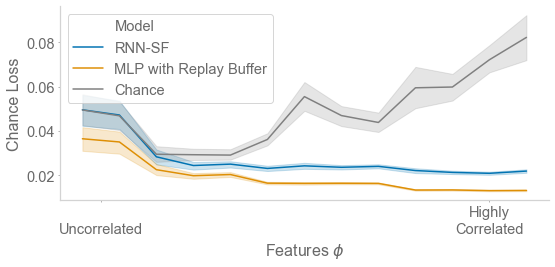

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(
    x='Sigma', y='Final Loss', hue='Model',
    ax = ax, data=df[(df['Gamma']==0.75)],
    hue_order=hue_order
    )
sns.lineplot(
    x='Sigma', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance'
    )
plt.xticks([0.5, np.unique(sigmas).size-2], ['\nUncorrelated', 'Highly\nCorrelated'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_corrlineplot.png', dpi=300)

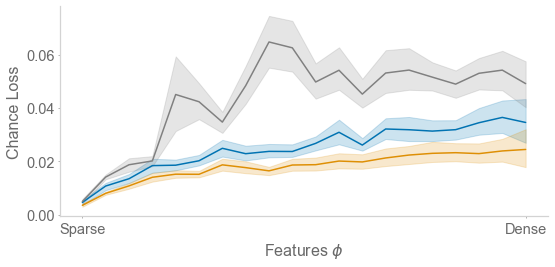

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(
    x='Sparsity', y='Final Loss', hue='Model',
    ax = ax, data=df[df['Gamma']==0.75],
    hue_order=hue_order, legend=None
    )
sns.lineplot(
    x='Sparsity', y='Chance Loss',
    ax = ax, data=df[(df['Gamma']==0.75) & (df['Model']=='RNN-SF')],
    color='Gray', label='Chance', legend=None
    )
xtick1 = df['Sparsity'].min()
xtick2 = df['Sparsity'].max()
plt.xticks([xtick1, xtick2], ['Sparse', 'Dense'])
plt.xlabel('Features $\phi$')
plt.tight_layout()
plt.savefig('4a_sparselineplot.png', dpi=300)

# Make 2D plots

In [10]:
np.unique(models)

array(['Linear', 'MLP with Replay Buffer', 'RNN-Oja', 'RNN-SF'],
      dtype='<U22')

In [11]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [12]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [13]:
plt.rcParams.update({'hatch.color': 'darkgray'})

In [14]:
def make_gradients(
    xs, ys, zs, models, cmap="Reds",
    plottype='RNN-SF', chance_relative=False, chance_zs=None,
    title=None, xlabel=None, ylabel=None,
    figname=None, figsize=[6.4, 4.8],
    interpolate=False, smooth=False, contours=None,
    leave_edge_nans=True, xlim=None
    ):
    
    # Collect data into a meshgrid
    xs = xs.astype(float)
    ys = ys.astype(float)
    zs = zs.astype(float)
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(
                np.logical_and(xs==x[i,j], ys==y[i,j]),
                models==plottype
                )
            _val = np.nanmean(zs[ij_idx])
            if chance_relative:
                _chance_val = np.nanmean(chance_zs[ij_idx])
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    
    # Plot raw grid values
    fig, ax = plt.subplots()
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]
            
        
    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)

    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x, y, z,
                     levels=levels, cmap=cmap
                     )
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if xlim is not None: # Adjust x limits
        plt.xlim(xlim)
    if contours is not None: # Draw contours
        cntrs = plt.contourf(
            x, y, z, contours,
            hatches='//', alpha=0.01,
            colors='white'
            )
        plt.clabel(cntrs, inline=True, fontsize=12)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

In [20]:
_gamma = 0.4

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

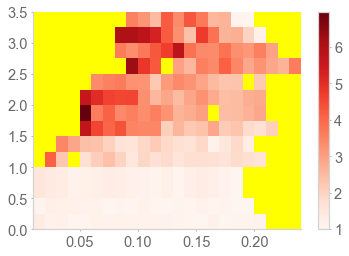

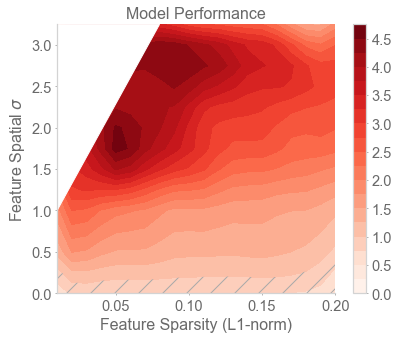

In [21]:
# RNN-SF
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==_gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-SF', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

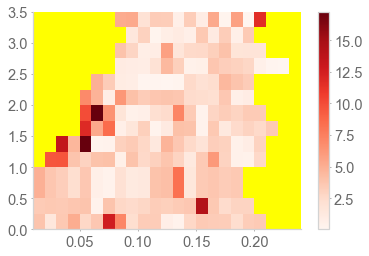

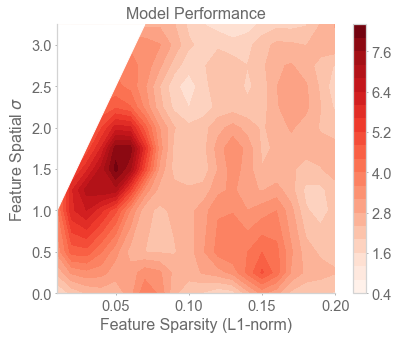

In [22]:
# RNN-Oja
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_rnn_oja_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='RNN-Oja', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Thi

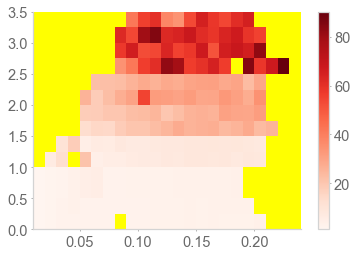

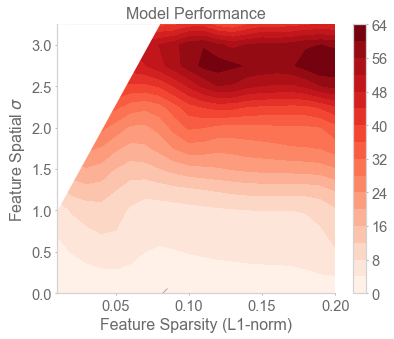

In [23]:
# Linear
_models = models[gammas==_gamma]
_sparsities = final_sparsities[gammas==_gamma]
_sigmas = sigmas[gammas==_gamma]
_final_losses = final_losses[gammas==_gamma]
_chance_losses = chance_losses[gammas==gamma]

_x, _y, _z = make_gradients(
    _sparsities, _sigmas,
    _final_losses, _models,
    title='Model Performance',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'4a_perf_linear_{_gamma}',
    interpolate=True, smooth=True, figsize=[6,5],
    plottype='Linear', chance_relative=True,
    chance_zs = _chance_losses, contours=[0.0, 1.0],
    xlim=[_sparsities.min(), 0.2]
    )

## Loss as a function of gamma

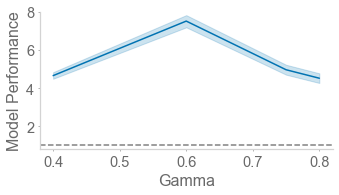

In [25]:
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='Gamma', y='Fold Improvement from Chance',
    hue='Model',
    ax = ax,
    data=df[df['Model'] == 'Linear'],
    legend=None
    )
ax.set_ylim(0.8)
ax.axhline(1.0, color='gray', linestyle='--')
ax.set_ylabel('Model Performance')
plt.tight_layout()
plt.savefig('4a_gamma_perf.png', dpi=300)